## Helioseismology project - Part 2
*Fourier* analysis of the sun's radial oscillations:

In [500]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit, differential_evolution
import warnings

# Matplolib style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

# # Reset matplolib style
# plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('seaborn-v0_8-pastel')

In [501]:
# Read data and stack the pandas dataframe into a single 1d array, reading lines consecutively
data_calib1_pm1 = pd.read_table('./DataSeries/data2_calib1_pm1_960411_961010.dat', sep = '\s+', header = None).stack().values
data_calib2_pm1 = pd.read_table('./DataSeries/data2_calib2_pm1_960411_961010.dat', sep = '\s+', header = None).stack().values
data_calib1_pm2 = pd.read_table('./DataSeries/data2_calib1_pm2_960411_961010.dat', sep = '\s+', header = None).stack().values
data_calib2_pm2 = pd.read_table('./DataSeries/data2_calib2_pm2_960411_961010.dat', sep = '\s+', header = None).stack().values
# Velocities are in cm/s, I think. Not sure if this is correct, though.

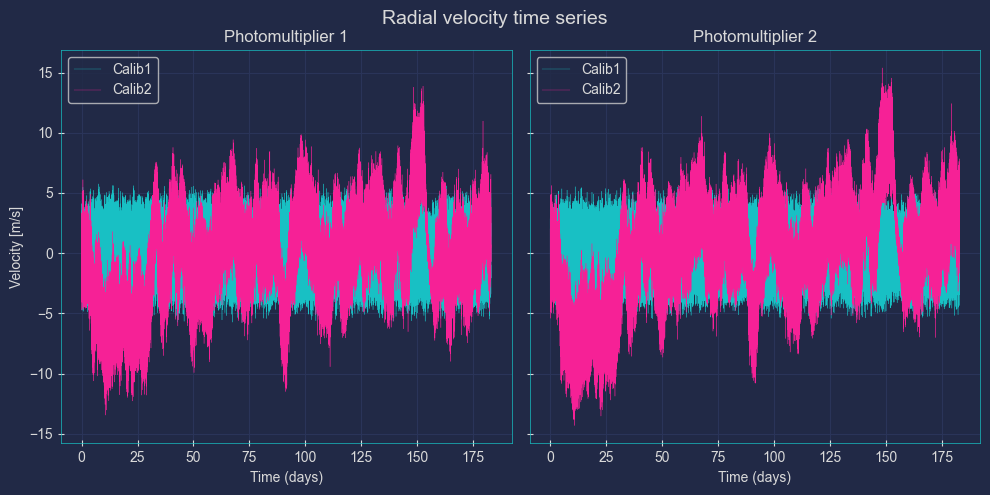

In [521]:
# Create two subplots to plot the data
days2sec = (3600*24)
fig, ax  = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
time     = np.arange(0, len(data_calib1_pm1) * 20 / days2sec, 20 / days2sec) # Time in days. Can also use 'np.linspace'.
                                                                             # Might be better/more consistent (t_step = 20s).
# Photomultiplier 1
ax[0].plot(time, data_calib1_pm1, linewidth = 0.25)
ax[0].plot(time, data_calib2_pm1, linewidth = 0.25)
ax[0].set_title('Photomultiplier 1')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Velocity [m/s]')
ax[0].legend(['Calib1', 'Calib2'], frameon = True, fancybox = True)

# Photomultiplier 2
ax[1].plot(time, data_calib1_pm2, linewidth = 0.25)
ax[1].plot(time, data_calib2_pm2, linewidth = 0.25)
ax[1].set_title('Photomultiplier 2')
ax[1].set_xlabel('Time (days)')
ax[1].legend(['Calib1', 'Calib2'], frameon = True, fancybox = True)

fig.suptitle('Radial velocity time series', fontsize = 14)
plt.tight_layout()
plt.subplots_adjust(top = 0.90)
plt.savefig('./Figures/CalibrationData.png', dpi = 300)
plt.show()

Calibration method 2 appears to have some sort of modulation to the signal, which I'm not sure we're supposed to have. Either way, I guess we are supposed to use method 2, based on what is said in Part 2 of the question paper (*Fourier* spectrum spike around $f = 0$), but I'm not sure why this is the case.

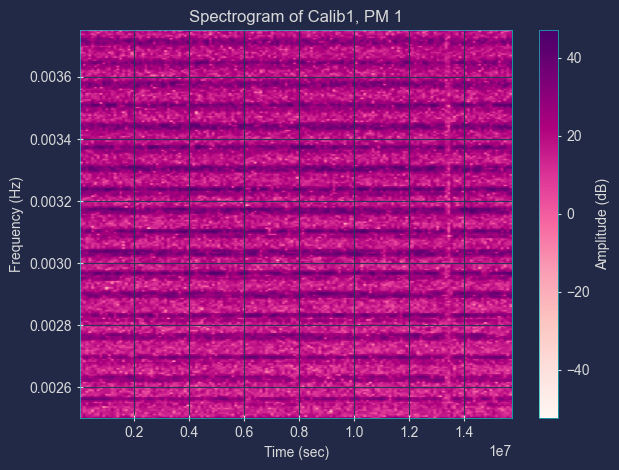

In [503]:
# Spectrogram test
NFFT = 10184; Test_plot = plt.specgram(data_calib1_pm1, Fs = 1./20., NFFT = NFFT, noverlap = NFFT//2)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.ylim(2.5e-3, 3.75e-3)
plt.title('Spectrogram of Calib1, PM 1')
plt.colorbar(label = 'Amplitude (dB)')
plt.tight_layout()
plt.savefig('./Figures/Spectrogram.png', dpi = 300)
plt.show()

Notice the dash around 250 Hz. This is also visible below, using the regular FFT algorithm.

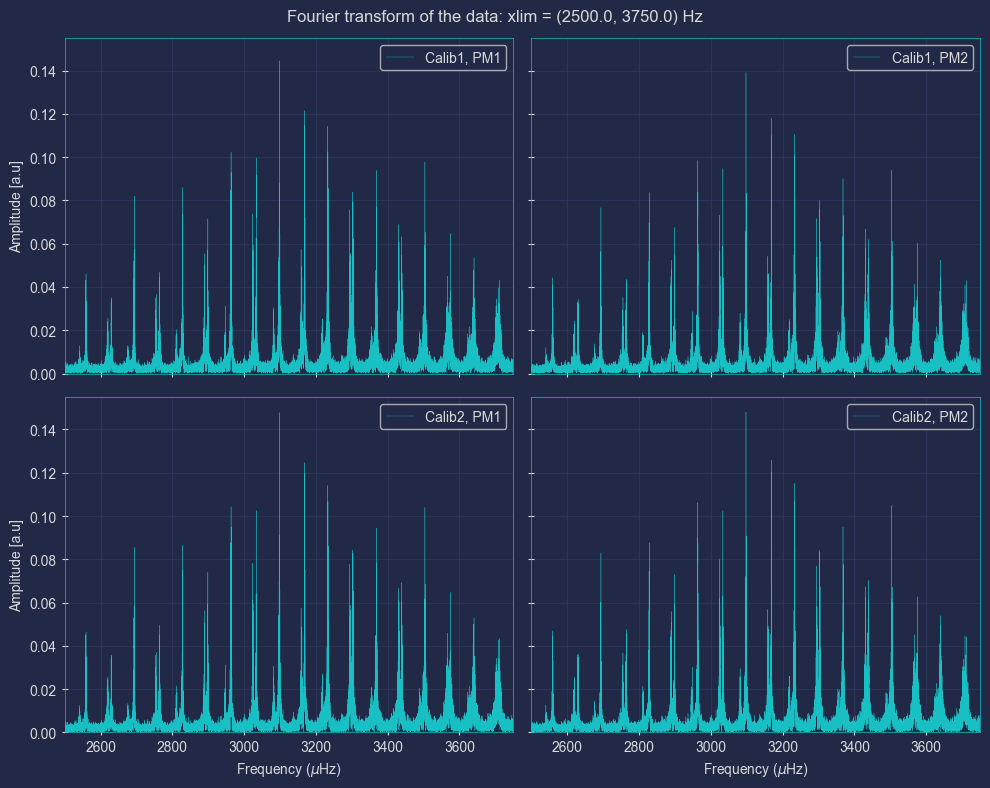

In [522]:
# Compute fourier transform using "scipy fftpack.fft" and plot results
N       = len(data_calib1_pm1)
T       = (time[1] - time[0]) * days2sec
x       = time; xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
y11     = data_calib1_pm1; y12 = data_calib1_pm2; y21 = data_calib2_pm1; y22 = data_calib2_pm2
y11f    = scipy.fftpack.fft(y11); y12f = scipy.fftpack.fft(y12); y21f = scipy.fftpack.fft(y21); y22f = scipy.fftpack.fft(y22)

# xlim = (2e3, 4.25e3)
xlim = (2.5e3, 3.75e3)
fig, ax = plt.subplots(2, 2, figsize = (10, 8), sharex = True, sharey = True)
ax[0, 0].plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), linewidth = 0.25, label = 'Calib1, PM1')
ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylim(0.0, 0.155)
# ax[0, 0].set_title('Calib1 - PM1')
ax[0, 0].set_ylabel('Amplitude [a.u]')
ax[0, 0].legend(frameon = True, fancybox = True)

ax[0, 1].plot(xf*1e6, 2.0/N * np.abs(y12f[:N//2]), linewidth = 0.25, label = 'Calib1, PM2')
# ax[0, 1].set_title('Calib1 - PM2')
ax[0, 1].legend(frameon = True, fancybox = True)

ax[1, 0].plot(xf*1e6, 2.0/N * np.abs(y21f[:N//2]), linewidth = 0.25, label = 'Calib2, PM1')
# ax[1, 0].set_title('Calib2 - PM1')
ax[1, 0].set_xlabel(r'Frequency ($\mu$Hz)')
ax[1, 0].set_ylabel('Amplitude [a.u]')
ax[1, 0].legend(frameon = True, fancybox = True)

ax[1, 1].plot(xf*1e6, 2.0/N * np.abs(y22f[:N//2]), linewidth = 0.25, label = 'Calib2, PM2')
# ax[1, 1].set_title('Calib2 - PM2')
ax[1, 1].set_xlabel(r'Frequency ($\mu$Hz)')
ax[1, 1].legend(frameon = True, fancybox = True)

fig.suptitle('Fourier transform of the data: xlim = ' + str(xlim) + ' Hz')
plt.tight_layout()
plt.savefig('./Figures/FourierTransformAll.png', dpi = 300)
plt.show()

# I still need to go through this FFT stuff, again. I'm not sure if I'm doing it right.
# Doing this analytically will help me understand, I think:
# - Sampling frequency and FFT frequency bins;
# - Nyquist frequency, etc.

In calibration method 2, there are high intensity peaks near $f = 0$. These correspond to DC components of our signal, i.e., the baseline velocity value around which the velocities oscillate is **not** zero. This can be seen in the velocity plots above.

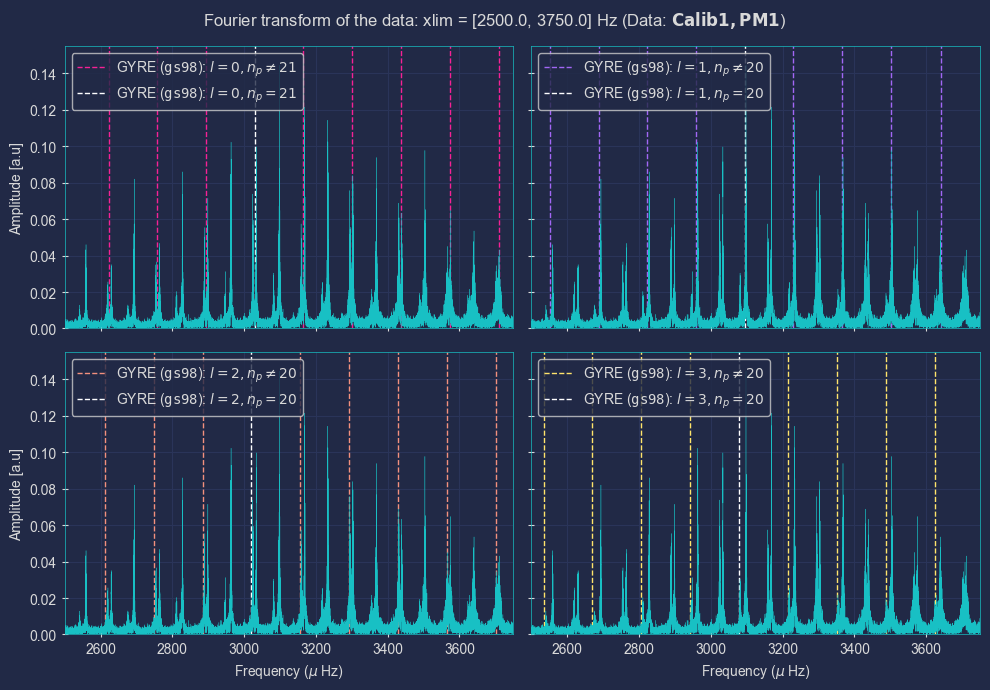

In [523]:
# Read MESA's frequency data, computed using GYRE, from 'freqs_summary_gs98_detail.txt'
freqs = pd.read_table('./freqs_summary_a09.txt', sep = '\s+', skiprows = 4, header = 1, \
                      dtype = {'l': 'Int64', 'n_p': 'Int64', 'n_g': 'Int64', 'n_pg': 'Int64'})

# Separate data by l and n_p
l0 = freqs[freqs['l'] == 0]; l1 = freqs[freqs['l'] == 1]; l2 = freqs[freqs['l'] == 2]; l3 = freqs[freqs['l'] == 3]
l0n21 = l0[l0['n_p'] == 21]; l1n20 = l1[l1['n_p'] == 20]; l2n20 = l2[l2['n_p'] == 20]; l3n20 = l3[l3['n_p'] == 20]
l0nx = l0[l0['n_p'] != 21];  l1nx = l1[l1['n_p'] != 20];  l2nx = l2[l2['n_p'] != 20];  l3nx = l3[l3['n_p'] != 20]

# Plotting simulation results, alongside experimental observations (from the GOLF experiment)
fig, ax = plt.subplots(2, 2, figsize = (10, 7), sharex = True, sharey = True)
ax[0, 0].vlines(l0nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C1', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 0, n_p \neq 21$')
ax[0, 0].vlines(l0n21['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 0, n_p = 21$')
ax[0, 0].plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), color = 'C0', linewidth = 0.25)
ax[0, 0].set_ylabel('Amplitude [a.u]')
ax[0, 0].set_xlim(xlim)
ax[0, 0].set_ylim(0.0, 0.155)
# ax[0, 0].set_title('Calib2 - PM2')
ax[0, 0].legend(frameon = True, fancybox = True)

ax[0, 1].vlines(l1nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C2', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 1, n_p \neq 20$')
ax[0, 1].vlines(l1n20['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 1, n_p = 20$')
ax[0, 1].plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), color = 'C0', linewidth = 0.25)
# ax[0, 1].set_title('Calib2 - PM2')
ax[0, 1].legend(frameon = True, fancybox = True)

ax[1, 0].vlines(l2nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C3', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 2, n_p \neq 20$')
ax[1, 0].vlines(l2n20['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 2, n_p = 20$')
ax[1, 0].plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), color = 'C0', linewidth = 0.25)
ax[1, 0].set_xlabel(r'Frequency ($\mu$ Hz)')
ax[1, 0].set_ylabel('Amplitude [a.u]')
# ax[1, 0].set_title('Calib2 - PM2')
ax[1, 0].legend(frameon = True, fancybox = True)

ax[1, 1].vlines(l3nx['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C4', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 3, n_p \neq 20$')
ax[1, 1].vlines(l3n20['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C5', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 3, n_p = 20$')
ax[1, 1].plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), color = 'C0', linewidth = 0.25)
ax[1, 1].set_xlabel(r'Frequency ($\mu$ Hz)')
# ax[1, 1].set_title('Calib2 - PM2')
ax[1, 1].legend(frameon = True, fancybox = True)

fig.suptitle(f'Fourier transform of the data: xlim = [{xlim[0]}, {xlim[1]}]' + r' Hz (Data: $\mathbf{Calib1, PM1}$)')
plt.tight_layout()
plt.savefig('./Figures/FourierTransform(1,1)+GYRE_Separated.png', dpi = 300)
plt.show()

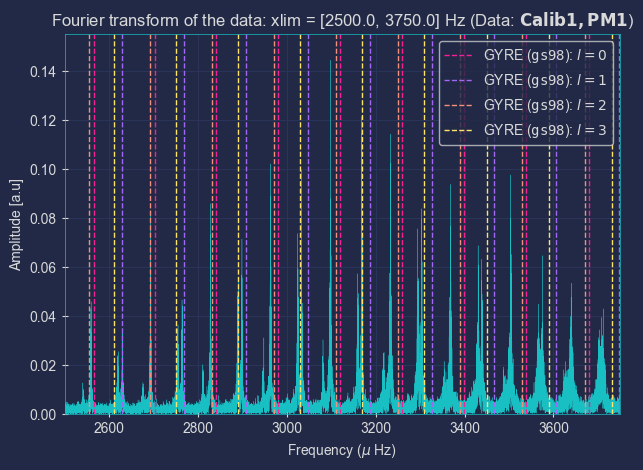

In [524]:
# Read MESA's frequency data, computed using GYRE, from 'freqs_summary_gs98.txt'
freqs = pd.read_table('./freqs_summary_gs98_detail.txt', sep = '\s+', skiprows = 4, header = 1, \
                      dtype = {'l': 'Int64', 'n_p': 'Int64', 'n_g': 'Int64', 'n_pg': 'Int64'})

# Separate data by l and n_p
l0 = freqs[freqs['l'] == 0]; l1 = freqs[freqs['l'] == 1]; l2 = freqs[freqs['l'] == 2]; l3 = freqs[freqs['l'] == 3]

# Plotting simulation results, alongside experimental observations (from the GOLF experiment)
plt.plot(xf*1e6, 2.0/N * np.abs(y11f[:N//2]), color = 'C0', linewidth = 0.25)
plt.vlines(l0['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C1', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 0$')
plt.vlines(l1['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C2', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 1$')
plt.vlines(l2['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C3', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 2$')
plt.vlines(l3['Re(freq)'], ymin = 0.0, ymax = 0.155, color = 'C4', linewidth = 1, \
           linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): $l = 3$')
plt.xlim(xlim)
plt.ylim(0.0, 0.155)
plt.xlabel(r'Frequency ($\mu$ Hz)')
plt.ylabel('Amplitude [a.u]')
plt.title(f'Fourier transform of the data: xlim = [{xlim[0]}, {xlim[1]}]' + r' Hz (Data: $\mathbf{Calib1, PM1}$)')
plt.legend(frameon = True, fancybox = True)
plt.tight_layout()
plt.savefig('./Figures/FourierTransform(1,1)+GYRE_Together.png', dpi = 300)
plt.show()

[MESA/GYRE] Average large separation (Sun) = 141.19111454020975 uHz.
[MESA/GYRE] Average small separation (Sun) = 73.24955986419066 uHz.
No xlim set.


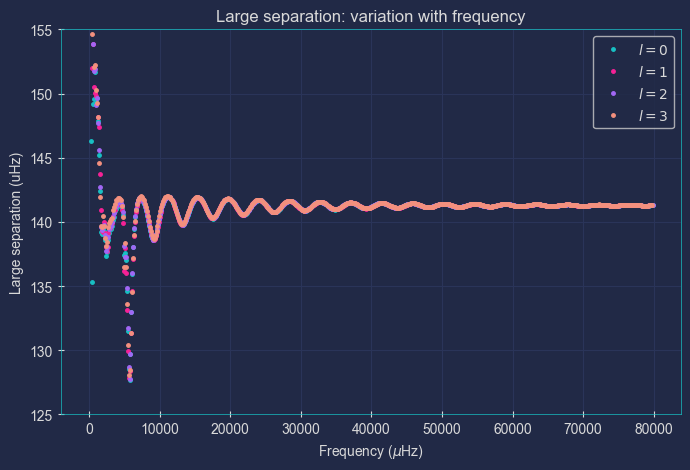

No xlim set.


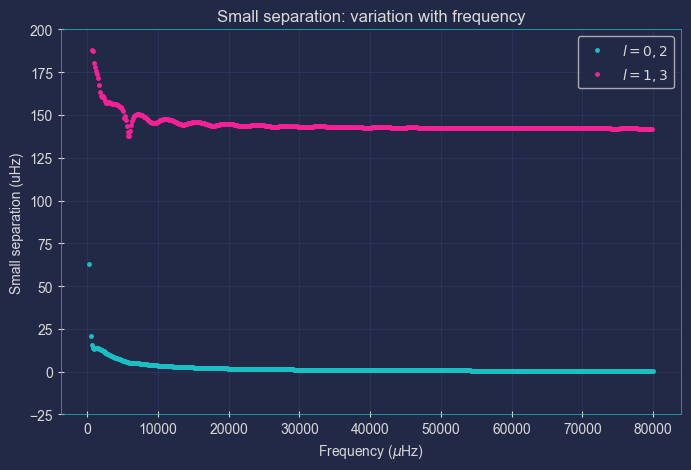

No xlim set.
No ylim set.


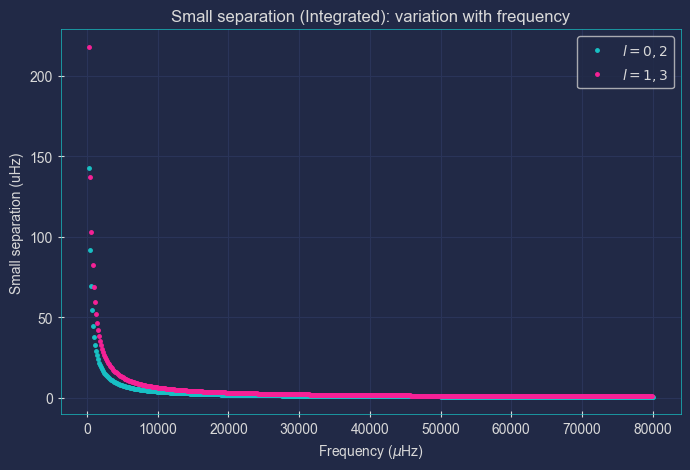

In [507]:
class Stellar_freqs:
    """
    Class to handle stellar frequency data.
    """

    # Constructor
    def __init__(self, freqs):
        self.freqs = freqs
        self.large_sep = self.get_large_sep()
        self.small_sep = self.get_small_sep()

    # String representation
    def __str__(self) -> str:
        return f'[MESA/GYRE] Average large separation (Sun) = {np.mean(self.large_sep)} uHz.\n\
[MESA/GYRE] Average small separation (Sun) = {self.small_sep} uHz.'

    # Class methods
    # Auxiliary method to return the frequency of a given mode,
    # given its angular number (l) and radial order, number o shells (n_p).
    def get_freq(self, l, n_p) -> float:
        """
        Returns the frequency of a given mode, given its angular number (l) and radial order, number o shells (n_p).
        """
        returned_freqs = self.freqs[(self.freqs['l'] == l) & (self.freqs['n_p'] == n_p)]['Re(freq)'].values
        if(len(returned_freqs) > 1): return np.mean(returned_freqs)
        else: return returned_freqs[0]

    # Returns uncertainty of a certain n, l mode.
    def get_err(self, l, n_p) -> float:
        """
        Returns the error/uncertainty of a given mode, given its angular number (l) and radial order, number o shells (n_p).
        """
        return self.freqs[(self.freqs['l'] == l) & (self.freqs['n_p'] == n_p)]['Re(freq)_Err'].values[0]
    
    # Large separation
    def get_large_sep(self) -> float:
        """
        Returns the large separation for a given star, given its frequency data.
        """
        large_sep = np.array([])
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p']) + 1):
                try:
                    large_sep = np.append(large_sep, self.get_freq(l, n+1) - self.get_freq(l, n))
                except IndexError:
                    pass
        return np.mean(large_sep)

    # Small separation
    def get_small_sep(self) -> float:
        """
        Returns the small separation for a given star, given its frequency data.
        """
        small_sep = np.array([])
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p']) + 1):
                try:
                    small_sep = np.append(small_sep, self.get_freq(l, n) - self.get_freq(l+2, n-1))
                except IndexError:
                    pass
        return np.mean(small_sep)
    
    # Plotting methods
    # Large separation as a function of frequency.
    def large_sep_plot(self, **kwargs):
        """
        Plots the large separation for a given star, given its frequency data.
        """
        large_sep = []
        if('Re(freq)_Err' in self.freqs.columns): error_bars = []
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p']) + 1):
                try:
                    large_sep.append((self.get_freq(l, n+1) - self.get_freq(l, n), n, l))
                    if('Re(freq)_Err' in self.freqs.columns): error_bars.append(np.sqrt(self.get_err(l, n+1)**2 + self.get_err(l, n)**2))
                except IndexError:
                    pass

        # Auxiliary lists, for aiding in plotting
        large_sep_l0 = [tuple for tuple in large_sep if tuple[2] == 0]; l0 = self.freqs[self.freqs['l'] == 0]
        large_sep_l1 = [tuple for tuple in large_sep if tuple[2] == 1]; l1 = self.freqs[self.freqs['l'] == 1]
        large_sep_l2 = [tuple for tuple in large_sep if tuple[2] == 2]; l2 = self.freqs[self.freqs['l'] == 2]
        large_sep_l3 = [tuple for tuple in large_sep if tuple[2] == 3]; l3 = self.freqs[self.freqs['l'] == 3]

        # Output lists
        y_l0 = [(freq[0], freq[1]) for freq in large_sep_l0]; y_l1 = [(freq[0], freq[1]) for freq in large_sep_l1]
        y_l2 = [(freq[0], freq[1]) for freq in large_sep_l2]; y_l3 = [(freq[0], freq[1]) for freq in large_sep_l3]

        # Error bars
        large_sep_l0_x = [l0[l0['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l0]
        try: large_sep_l0_x_Err = [l0[l0['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l0]
        except KeyError: pass
        large_sep_l1_x = [l1[l1['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l1]
        try: large_sep_l1_x_Err = [l1[l1['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l1]
        except KeyError: pass
        large_sep_l2_x = [l2[l2['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l2]
        try: large_sep_l2_x_Err = [l2[l2['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l2]
        except KeyError: pass
        large_sep_l3_x = [l3[l3['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in large_sep_l3]
        try: large_sep_l3_x_Err = [l3[l3['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in large_sep_l3]
        except KeyError: pass

        fig, ax = plt.subplots(figsize = (8, 5))
        # Plotting data
        ax.plot(large_sep_l0_x, [freq[0] for freq in large_sep_l0], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0$')
        ax.plot(large_sep_l1_x, [freq[0] for freq in large_sep_l1], 'o', markersize = 2.5, color = 'C1', label = r'$l = 1$')
        ax.plot(large_sep_l2_x, [freq[0] for freq in large_sep_l2], 'o', markersize = 2.5, color = 'C2', label = r'$l = 2$')
        ax.plot(large_sep_l3_x, [freq[0] for freq in large_sep_l3], 'o', markersize = 2.5, color = 'C3', label = r'$l = 3$')
        
        # Plotting error bars: both x and y.
        if('Re(freq)_Err' in self.freqs.columns):
            # Auxiliary lists, for aiding in plotting the error bars
            error_bars_l0 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 0]
            error_bars_l1 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 1]
            error_bars_l2 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 2]
            error_bars_l3 = [error_bars[i] for i in range(len(error_bars)) if large_sep[i][2] == 3]

            try: ax.errorbar(large_sep_l0_x, [freq[0] for freq in large_sep_l0], xerr = np.array(large_sep_l0_x_Err)*100, yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l0_x, [freq[0] for freq in large_sep_l0], yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(large_sep_l1_x, [freq[0] for freq in large_sep_l1], xerr = np.array(large_sep_l1_x_Err)*100, yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l1_x, [freq[0] for freq in large_sep_l1], yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(large_sep_l2_x, [freq[0] for freq in large_sep_l2], xerr = np.array(large_sep_l2_x_Err)*100, yerr = np.array(error_bars_l2)*100, fmt = 'none', ecolor = 'C2', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l2_x, [freq[0] for freq in large_sep_l2], yerr = np.array(error_bars_l2)*100, fmt = 'none', ecolor = 'C2', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(large_sep_l3_x, [freq[0] for freq in large_sep_l3], xerr = np.array(large_sep_l3_x_Err)*100, yerr = np.array(error_bars_l3)*100, fmt = 'none', ecolor = 'C3', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(large_sep_l3_x, [freq[0] for freq in large_sep_l3], yerr = np.array(error_bars_l3)*100, fmt = 'none', ecolor = 'C3', label = r'$100 \times \sigma$', alpha = 0.5)
            ax.legend(ncol = 2, frameon = True, fancybox = True)
        else:
            ax.legend(frameon = True, fancybox = True)
        ax.set_xlabel(r'Frequency ($\mu$Hz)')
        ax.set_ylabel('Large separation (uHz)')

        # Title setting
        try: ax.set_title(kwargs['title'])
        except KeyError: ax.set_title('Large separation: variation with frequency')

        # Limit setting
        try: ax.set_xlim(kwargs['xlim'])
        except KeyError: print('No xlim set.'); pass
        try: ax.set_ylim(kwargs['ylim'])
        except KeyError: print('No ylim set.'); pass
        try: plt.savefig(f'./Figures/LargeSeparation_' + kwargs['append_name'] + '.png', dpi = 300)
        except KeyError: plt.savefig('./Figures/LargeSeparation.png', dpi = 300)
        plt.show()

        # Return the small separation for l = 0, l = 1, l = 2, l = 3.
        try: return y_l0, y_l1, y_l2, y_l3
        except NameError: pass

    # Small separation as a function of frequency.
    def small_sep_plot(self, **kwargs):
        """
        Plots the small separation for a given star, given its frequency data.
        """
        small_sep = []
        if('Re(freq)_Err' in self.freqs.columns): error_bars = []
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p']) + 1):
                try:
                    # Trying this scaling factor from https://articles.adsabs.harvard.edu//full/1993ASPC...42..347C/0000348.000.html
                    # scaling_factor = 3/(2*l + 3)
                    # small_sep.append((scaling_factor * (self.get_freq(l, n) - self.get_freq(l+2, n-1)), n, l))
                    small_sep.append((self.get_freq(l, n) - self.get_freq(l+2, n-1), n, l))
                    if('Re(freq)_Err' in self.freqs.columns): error_bars.append(np.sqrt(self.get_err(l, n)**2 + self.get_err(l+2, n-1)**2))
                except IndexError:
                    pass

        # Auxiliary lists, for aiding in plotting
        small_sep_l0 = [tuple for tuple in small_sep if tuple[2] == 0]; l0 = self.freqs[self.freqs['l'] == 0]
        small_sep_l1 = [tuple for tuple in small_sep if tuple[2] == 1]; l1 = self.freqs[self.freqs['l'] == 1]
        y_l0 = np.array([(freq[0], freq[1]) for freq in small_sep_l0]); y_l1 = np.array([(freq[0], freq[1]) for freq in small_sep_l1])

        small_sep_l0_x = [l0[l0['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in small_sep_l0]
        try: small_sep_l0_x_Err = [l0[l0['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in small_sep_l0]
        except KeyError: pass
        small_sep_l1_x = [l1[l1['n_p'] == freq[1]]['Re(freq)'].values[0] for freq in small_sep_l1]
        try: small_sep_l1_x_Err = [l1[l1['n_p'] == freq[1]]['Re(freq)_Err'].values[0] for freq in small_sep_l1]
        except KeyError: pass

        # Defining the figure and axes
        fig, ax = plt.subplots(figsize = (8, 5))
        ax.plot(small_sep_l0_x, [freq[0] for freq in small_sep_l0], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0, 2$')
        ax.plot(small_sep_l1_x, [freq[0] for freq in small_sep_l1], 'o', markersize = 2.5, color = 'C1', label = r'$l = 1, 3$')
        if('Re(freq)_Err' in self.freqs.columns):
            # Auxiliary lists, for aiding in plotting the error bars
            error_bars_l0 = [error_bars[i] for i in range(len(error_bars)) if small_sep[i][2] == 0]
            error_bars_l1 = [error_bars[i] for i in range(len(error_bars)) if small_sep[i][2] == 1]
            # Plotting error bars: both x and y.
            try: ax.errorbar(small_sep_l0_x, [freq[0] for freq in small_sep_l0], xerr = np.array(small_sep_l0_x_Err)*100, yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(small_sep_l0_x, [freq[0] for freq in small_sep_l0], yerr = np.array(error_bars_l0)*100, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar(small_sep_l1_x, [freq[0] for freq in small_sep_l1], xerr = np.array(small_sep_l1_x_Err)*100, yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar(small_sep_l1_x, [freq[0] for freq in small_sep_l1], yerr = np.array(error_bars_l1)*100, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            ax.legend(ncol = 2, frameon = True, fancybox = True)
        else:
            ax.legend(frameon = True, fancybox = True)
        ax.set_xlabel(r'Frequency ($\mu$Hz)')
        ax.set_ylabel('Small separation (uHz)')

        # Title setting
        try: ax.set_title(kwargs['title'])
        except KeyError: ax.set_title('Small separation: variation with frequency')

        # Limit setting
        try: ax.set_xlim(kwargs['xlim'])
        except KeyError: print('No xlim set.'); pass
        try: ax.set_ylim(kwargs['ylim'])
        except KeyError: print('No ylim set.'); pass
        try: plt.savefig(f'./Figures/SmallSeparation_' + kwargs['append_name'] + '.png', dpi = 300)
        except KeyError: plt.savefig('./Figures/SmallSeparation.png', dpi = 300)
        plt.show()
        
        # Return the small separation for l = 0 and l = 1
        try: return y_l0, y_l1
        except NameError: pass
    
    def small_sep_plot_Integrated(self, **kwargs):
        # Values taken from the calculations at the end of "csound.ipynb"
        # Delta_nu = 145.84224662684176 # [uHz] (gs98)
        Delta_nu = 142.51953828958793 # [uHz] (a09)
        # r_Integral = -0.0017811448153391323 # (gs98)
        r_Integral = -0.0017500498955612 # (a09)
        
        # Required auxiliary lists
        delta_nu_list = []
        if('Re(freq)_Err' in self.freqs.columns): error_bars = []

        # Calculating the small separation for each mode, and appending it to a list
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p']) + 1):
                try:
                    delta_nu_nl = -r_Integral*Delta_nu/(4*np.pi**2*self.get_freq(l, n))*(4*l+6)*1e6
                    if('Re(freq)_Err' in self.freqs.columns):
                        delta_nu_list.append((self.get_freq(l, n), delta_nu_nl, n, l, self.get_err(l, n)))
                        # error_bars.append(np.abs((4*l + 6)/(4 * np.pi**2) * (Delta_nu * r_Integral/(self.get_freq(l, n)**2) * self.get_err(l, n) * 1e6)))
                        error = (4*l + 6)/(4 * np.pi**2)*np.sqrt( ( r_Integral*1e6/self.get_freq(l, n) * 1e-10 )**2 + \
                                                                  ( Delta_nu/self.get_freq(l, n) * 1e-10 *1e6 )**2 + \
                                                                  ( Delta_nu * r_Integral*1e6 /(self.get_freq(l, n)**2) * self.get_err(l, n) )**2 )
                        error_bars.append(error)
                    else:
                        delta_nu_list.append((self.get_freq(l, n), delta_nu_nl, n, l))
                except IndexError:
                    pass
        
        # Auxiliary lists, for aiding in plotting
        delta_nu_l0 = [tuple for tuple in delta_nu_list if tuple[3] == 0]; delta_nu_l1 = [tuple for tuple in delta_nu_list if tuple[3] == 1]
        y_l0 = np.array([(freq[0], freq[1]) for freq in delta_nu_l0]); y_l1 = np.array([(freq[0], freq[1]) for freq in delta_nu_l1])
        
        # Plot l = 0, 2 and l = 1, 3
        fig, ax = plt.subplots(figsize = (8, 5)) # Defining the figure and axes
        ax.plot([freq[0] for freq in delta_nu_l0], [freq[1] for freq in delta_nu_l0], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0, 2$')
        ax.plot([freq[0] for freq in delta_nu_l1], [freq[1] for freq in delta_nu_l1], 'o', markersize = 2.5, color = 'C1', label = r'$l = 1, 3$')
        if('Re(freq)_Err' in self.freqs.columns):
            # Auxiliary lists, for aiding in plotting the error bars
            # "yerr"
            error_bars_l0 = [error_bars[i] for i in range(len(error_bars)) if delta_nu_list[i][3] == 0]
            error_bars_l1 = [error_bars[i] for i in range(len(error_bars)) if delta_nu_list[i][3] == 1]

            # "xerr"
            small_sep_l0_x_Err = [delta_nu_list[i][4] for i in range(len(delta_nu_list)) if delta_nu_list[i][3] == 0]
            small_sep_l1_x_Err = [delta_nu_list[i][4] for i in range(len(delta_nu_list)) if delta_nu_list[i][3] == 1]

            # Plotting error bars: both x and y.
            try: ax.errorbar([freq[0] for freq in delta_nu_l0], [freq[1] for freq in delta_nu_l0], xerr = np.array(small_sep_l0_x_Err)*1000, yerr = np.array(error_bars_l0)*1000, fmt = 'none', ecolor = 'C0', label = r'$1000 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar([freq[0] for freq in delta_nu_l0], [freq[1] for freq in delta_nu_l0], yerr = np.array(error_bars_l0)*1000, fmt = 'none', ecolor = 'C0', label = r'$100 \times \sigma$', alpha = 0.5)
            try: ax.errorbar([freq[0] for freq in delta_nu_l1], [freq[1] for freq in delta_nu_l1], xerr = np.array(small_sep_l1_x_Err)*1000, yerr = np.array(error_bars_l1)*1000, fmt = 'none', ecolor = 'C1', label = r'$1000 \times \sigma$', alpha = 0.5)
            except NameError: ax.errorbar([freq[0] for freq in delta_nu_l1], [freq[1] for freq in delta_nu_l1], yerr = np.array(error_bars_l1)*1000, fmt = 'none', ecolor = 'C1', label = r'$100 \times \sigma$', alpha = 0.5)
            ax.legend(ncol = 2, frameon = True, fancybox = True)
        else:
            ax.legend(frameon = True, fancybox = True)
        ax.set_xlabel(r'Frequency ($\mu$Hz)')
        ax.set_ylabel('Small separation (uHz)')

         # Title setting
        try: ax.set_title(kwargs['title'])
        except KeyError: ax.set_title('Small separation (Integrated): variation with frequency')

        # Limit setting
        try: ax.set_xlim(kwargs['xlim'])
        except KeyError: print('No xlim set.'); pass
        try: ax.set_ylim(kwargs['ylim'])
        except KeyError: print('No ylim set.'); pass
        try: plt.savefig(f'./Figures/SmallSeparationIntegrated_' + kwargs['append_name'] + '.png', dpi = 300)
        except KeyError: plt.savefig('./Figures/SmallSeparationIntegrated.png', dpi = 300)
        plt.show()
        
        # Return the small separation for l = 0, 2 and l = 1, 3.
        try: return y_l0, y_l1, delta_nu_list
        except NameError: pass

    def plot_echelle(self, **kwargs) -> dict:
        """
        Plots the echelle diagram for a given star, given its frequency data.
        """
        echelle_dict = {}; temp_list = []
        # Creating a dictionary with the frequencies, for each l. (Echelle diagram data)
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            for n in range(np.min(self.freqs['n_p']), np.max(self.freqs['n_p']) + 1):
                try:
                    temp_list.append((self.get_freq(l, n) % self.large_sep, self.get_freq(l, n)))
                except IndexError:
                    pass
            # Populating the dictionary and clearing the auxiliary list
            echelle_dict[l] = temp_list
            temp_list = []
        
        # Plotting Echele diagram
        print(f'Plotting Echelle diagram... Using' + r' $\Delta \nu$ = ' + f'{self.large_sep} uHz.')
        fig, ax = plt.subplots(figsize = (8, 5)) # Defining the figure and axes
        for l in range(np.min(self.freqs['l']), np.max(self.freqs['l']) + 1):
            ax.plot([freq[0] for freq in echelle_dict[l]], [freq[1] for freq in echelle_dict[l]], 'o', markersize = 2.5, label = f'l = {l}')
        
        # Plotting large separation for reference/visualization
        ax.vlines(self.large_sep, ymin = 0.0, ymax = 1e6, linewidth = 1, \
                   linestyle = '--', color = 'C4', label = rf'Large sep.:'
                    '\n'
                    rf'$\Delta \nu$ = {self.large_sep:.1f} $\mu$Hz')
        ax.set_xlabel(r'Frequency mod. large separation ($\mu$Hz)')
        ax.set_ylabel(r'Frequency ($\mu$Hz)')
        ax.legend(frameon = True, fancybox = True, ncols = 2)

        # Title setting
        try: ax.set_title(kwargs['title'])
        except KeyError: ax.set_title('Echelle diagram')

        # Limit setting
        try: ax.set_xlim(kwargs['xlim'])
        except KeyError: print('No xlim set.'); pass
        try: ax.set_ylim(kwargs['ylim'])
        except KeyError: print('No ylim set.'); pass

        # Show and save figure
        try: plt.savefig(f'./Figures/EchelleDiagram_' + kwargs['append_name'] + '.png', dpi = 300)
        except KeyError: plt.savefig('./Figures/EchelleDiagram.png', dpi = 300)
        plt.show()
        
        return echelle_dict
    
# Create an instance of the Stellar_freqs class
Freqs_MESA_obj = Stellar_freqs(freqs)
print(Freqs_MESA_obj)
_, _, _, _ = Freqs_MESA_obj.large_sep_plot(ylim = (125, 155), append_name = 'MESA_all')
_, _ = Freqs_MESA_obj.small_sep_plot(ylim = (-25, 200), append_name = 'MESA_all')
_, _, _ = Freqs_MESA_obj.small_sep_plot_Integrated(append_name = 'MESA_all')

Now attempting the experimental data's fitting with Lorentzian functions:

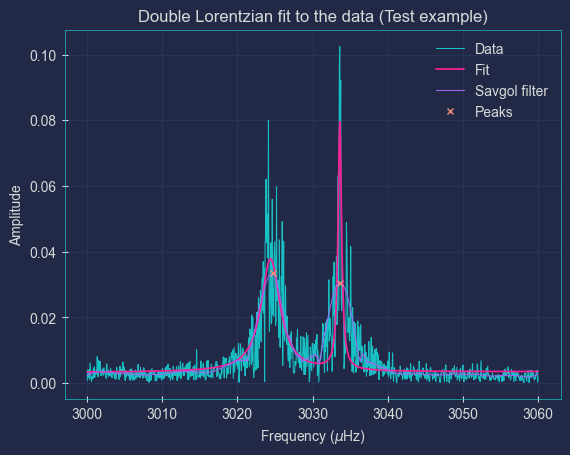

Linear off-set: a = 3.129554348643221e-06, b = -0.006090824983515719;
Peak 1: A = 0.06678811619500458, w = 0.5647819929210492, x_0 = 3033.6198002004735;
Peak 2: A1 = 0.16547031491891423, w1 = 3.0636514678920186, x_01 = 3024.409488706276.


In [508]:
xlim_Window = (3000.0, 3060.0)
xData, yData = xf*1e6, 2.0/N * np.abs(y22f[:N//2])

yData = yData[(xData > xlim_Window[0]) & (xData < xlim_Window[1])]
xData = xData[(xData > xlim_Window[0]) & (xData < xlim_Window[1])]

# Double Lorentzian peak function
# Bounds on parameters are set in generate_Initial_Parameters() below
def double_Lorentz(x, a, b,      \
                   A, w, x_0,    \
                   A1, w1, x_01):
    """
    Double Lorentzian peak function. Parameters:
    a    - Linear off-set;
    b    - Constant off-set;
    A    - Scale factor of the first peak;
    w    - FWHM of the first peak;
    x_0  - Center of the first peak;
    A1   - Scale factor of the second peak;
    w1   - FWHM of the second peak;
    x_01 - Center of the second peak,
    """

    return a*x + b + \
           (2*A/np.pi)*(w/(4*(x-x_0)**2 + w**2)) + \
           (2*A1/np.pi)*(w1/(4*(x-x_01)**2 + w1**2))


# Function for genetic algorithm to minimize (sum of squared error)
# Bounds on parameters are set in generate_Initial_Parameters() below
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # Do not print warnings by genetic algorithm
    return np.sum((yData - double_Lorentz(xData, *parameterTuple)) ** 2)


def generate_Initial_Parameters():
    # Min and max used for bounds
    maxX = max(xData); maxY = max(yData)
    minX = min(xData); minY = min(yData)
    
    parameterBounds = []
    parameterBounds.append([-1.0, 1.0])           # Parameter bounds for a
    parameterBounds.append([maxY/-2.0, maxY/2.0]) # Parameter bounds for b

    parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A
    parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w
    parameterBounds.append([minX, maxX])          # Parameter bounds for x_0

    parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A1
    parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w1
    parameterBounds.append([minX, maxX])          # Parameter bounds for x_01

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed = 3)
    return result.x

# Load the pickled test data from original Raman spectroscopy
xData = xData
yData = yData

# Find peaks 
yhat = savgol_filter(yData, 90, 3) # window size 51, polynomial order 3
id_peaks_in_window, _ = find_peaks(yhat, prominence = 0.020)

# Generate initial parameter values
initialParameters = generate_Initial_Parameters()

# Curve fit the test data
fittedParameters, pcov = curve_fit(double_Lorentz, xData, yData, initialParameters)

# Create values for display of fitted peak function
a, b, A, w, x_0, A1, w1, x_01 = fittedParameters
y_fit = double_Lorentz(xData, *fittedParameters)

plt.plot(xData, yData, linewidth = 0.75) # Plot the raw data
plt.plot(xData, y_fit, linewidth = 1.25) # Plot the equation using the fitted parameters
plt.plot(xData, yhat, linewidth = 0.75)  # Plot the smoothed data
plt.plot(xData[id_peaks_in_window], yhat[id_peaks_in_window], 'x', color = 'C3', markersize = 5)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Amplitude')
plt.title('Double Lorentzian fit to the data (Test example)')
plt.legend(['Data', 'Fit', 'Savgol filter', 'Peaks'])
plt.show()

print(f'Linear off-set: a = {a}, b = {b};\n\
Peak 1: A = {A}, w = {w}, x_0 = {x_0};\n\
Peak 2: A1 = {A1}, w1 = {w1}, x_01 = {x_01}.')

In [529]:
class Progressive_Lorentz_Fitter:
    """
    Class to fit a double Lorentzian peak, progressively, to a given data set.
    """

    # Constructor
    def __init__(self, xData, yData, l0, l1, l2, l3, itSkip, window_size = 1000):
        # GOLF data ('xData', 'yData') & others
        self.xData = xData
        self.yData = yData
        self.window_size = window_size
        self.current_pos = itSkip * window_size
        self.xData_window = xData[self.current_pos:self.current_pos + self.window_size]
        self.yData_window = yData[self.current_pos:self.current_pos + self.window_size]
        self.itSkip = itSkip
        self.ctr = 0
        self.npeaks = None; self.id_peaks_in_window = None; self.yhat = None; self.find_peaks()
        self.centered = False

        # MESA/GYRE simulations frequency data
        self.l0 = l0
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3

        # Fitting variables
        self.fittedParameters = None; self.pcov = None; self.y_fit = None; self.freqs = [] # ; self.fit_window()

    # String representation
    def __str__(self) -> str:
        try:
            return f'Linear off-set: a = {self.fittedParameters[0]}, b = {self.fittedParameters[1]};\n\
Peak 1: A = {self.fittedParameters[2]}, w = {self.fittedParameters[3]}, x_0 = {self.fittedParameters[4]};\n\
Peak 2: A1 = {self.fittedParameters[5]}, w1 = {self.fittedParameters[6]}, x_01 = {self.fittedParameters[7]}.'
        except TypeError:
            return 'No fit has been performed, yet.'
    
    # Class methods
    def find_peaks(self, prominence = 0.0015, distance = 100, width = 25):
        """
        Finds the peaks in the current window.
        """
        # Savitzky-Golay filter parameters
        sav_polynomial_order = 3
        sav_window_size      = 90

        self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
        self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
        self.npeaks = len(self.id_peaks_in_window)
        if(self.npeaks == 1):
            # Shift right, so we can find the other peak (they *always* come in pairs)
            shift = 200
            self.xData_window = self.xData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.yData_window = self.yData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.current_pos += shift
            self.centered = False
            
            # Fit again
            self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
            self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
            self.npeaks = len(self.id_peaks_in_window)
            if(self.npeaks == 1):
                # Shift left now, so we can find the other peak (they *always* come in pairs)
                shift = 400
                self.xData_window = self.xData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                self.yData_window = self.yData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                self.current_pos -= shift
                self.centered = False
                
                # Fit again
                self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
                self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
                self.npeaks = len(self.id_peaks_in_window)
        if((self.npeaks == 2)):
            if(self.id_peaks_in_window[1] - self.id_peaks_in_window[0] > 450):
                # This is the case in which we are fitting two non-consecutive peaks (bad)!
                # Shift right, so we can find the other peak (they *always* come in pairs)
                shift = self.window_size//2
                self.xData_window = self.xData[self.current_pos + shift:self.current_pos + self.window_size + shift]
                self.yData_window = self.yData[self.current_pos + shift:self.current_pos + self.window_size + shift]
                self.current_pos += shift
                self.centered = False
                # Fit again
                self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
                self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
                self.npeaks = len(self.id_peaks_in_window)
                if(self.npeaks == 1):
                    # Shift left now, so we can find the other peak (they *always* come in pairs)
                    shift = self.window_size
                    self.xData_window = self.xData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                    self.yData_window = self.yData[self.current_pos - shift:self.current_pos + self.window_size - shift]
                    self.current_pos -= shift
                    self.centered = False
                    # Fit again
                    self.yhat = savgol_filter(self.yData_window, sav_window_size, sav_polynomial_order) # Window size 90, polynomial order 3
                    self.id_peaks_in_window, _ = find_peaks(self.yhat, prominence = prominence, distance = distance, width = width)
                    self.npeaks = len(self.id_peaks_in_window)

    def center_peaks(self):
        """
        Centers the peaks in the current window.
        """
        if((self.npeaks == 2) & (self.centered == False)):
            # Auxiliary definitions
            avg_peak_id      = (self.id_peaks_in_window[0] + self.id_peaks_in_window[1])//2
            shift            = avg_peak_id - self.window_size//2
            
            # Shifting the window to center the peaks, so the fit is more accurate
            self.xData_window = self.xData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.yData_window = self.yData[self.current_pos + shift:self.current_pos + self.window_size + shift]
            self.current_pos += shift

            # Update the 'centered' flag
            self.centered = True

            # Recalculate peaks' positions
            self.find_peaks()

        elif((self.npeaks == 1) & (self.centered == False)): # This will never happen now.
            pass

    def plot_window(self, SavGol = True):
        """
        Plots the current window.
        """
        # Plotting for visualisation/debugging aid
        print(f'MeanY = {np.mean(self.yData_window)}. xData_window = [{self.xData_window[0]}, {self.xData_window[-1]}].')
        xlim = (min(self.xData_window), max(self.xData_window))
        plt.plot(self.xData_window, self.yData_window, linewidth = 0.5, label = 'GOLF data')

        # MESA/GYRE frequency results
        for cnt, l_mode in enumerate([self.l0, self.l1, self.l2, self.l3]):
            plt.vlines(l_mode['Re(freq)'], ymin = 0.0, ymax = 0.155, color = f'C{cnt + 1}', linewidth = 1, \
                       linestyle = '--', label = r'GYRE ($\mathtt{gs98}$): ' rf'$l = {cnt}$')
        
        # Peaks detected in the current window
        plt.plot(self.xData_window[self.id_peaks_in_window], self.yhat[self.id_peaks_in_window], \
                 "xC5", label = 'Detected peaks')

        # Plot the fitted function (if already fitted)
        if(self.fittedParameters is not None):
            plt.plot(self.xData_window, self.y_fit, label = 'Fitted function', color = 'paleturquoise')

        # Plot the Savitzky-Golay filter (if desired). Helps the peak-detection algorithm.
        if(SavGol == True):
            plt.plot(self.xData_window, self.yhat, label = 'Savitzky-Golay filter', color = 'lightcoral', linestyle = 'dashdot')

        plt.xlim(xlim)
        plt.ylim(0.0, 0.155)
        plt.xlabel(r'Frequency ($\mu$ Hz)')
        plt.ylabel('Amplitude [a.u]')
        plt.title(f'Fourier transform of the data: xlim = [{xlim[0]:.2f}, {xlim[1]:.2f}]' + r' $\mu$Hz (Data: $\mathbf{Calib1, Photomultiplier1}$)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def advance_window(self):
        """
        Advances the window by one step.
        """
        try:
            self.ctr += 1
            self.yData_window = self.yData[self.current_pos + self.window_size: self.current_pos + 2 * self.window_size]
            self.xData_window = self.xData[self.current_pos + self.window_size: self.current_pos + 2 * self.window_size]
            self.current_pos += self.window_size

            # Update the 'centered' flag & other variables
            self.centered = False
            self.npeaks = None; self.id_peaks_in_window = None; 
            self.y_fit = None; self.fittedParameters = None; self.pcov = None; self.find_peaks()
        except IndexError:
            self.ctr -= 1
            print('End of data reached.')

    # Fitting routine auxiliary functions:
    def fit_window(self):
        """
        Fits the current window.
        """
        if(self.npeaks == 2):
            print(f'Fitting window {self.ctr}...')
            self.center_peaks()
            # Double Lorentzian peak function
            # Bounds on parameters are set in generate_Initial_Parameters() below
            def double_Lorentz(x, a, b,      \
                               A, w, x_0,    \
                               A1, w1, x_01):
                """
                Double Lorentzian peak function. Parameters:
                a    - Linear off-set;
                b    - Constant off-set;
                A    - Scale factor of the first peak;
                w    - FWHM of the first peak;
                x_0  - Center of the first peak;
                A1   - Scale factor of the second peak;
                w1   - FWHM of the second peak;
                x_01 - Center of the second peak,
                """

                return a*x + b + \
                       (2*A/np.pi)*(w/(4*(x-x_0)**2 + w**2)) + \
                       (2*A1/np.pi)*(w1/(4*(x-x_01)**2 + w1**2))

            # Function for genetic algorithm to minimize (sum of squared error)
            # Bounds on parameters are set in generate_Initial_Parameters() below
            def sumOfSquaredError(parameterTuple):
                warnings.filterwarnings("ignore") # Do not print warnings by genetic algorithm
                return np.sum((self.yData_window - double_Lorentz(self.xData_window, *parameterTuple)) ** 2)

            def generate_Initial_Parameters():
                # Min and max used for bounds
                maxX = max(self.xData_window); maxY = max(self.yData_window)
                minX = min(self.xData_window); minY = min(self.yData_window)

                parameterBounds = []
                parameterBounds.append([-1.0, 1.0])           # Parameter bounds for a
                parameterBounds.append([maxY/-2.0, maxY/2.0]) # Parameter bounds for b

                parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A
                parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w
                # parameterBounds.append([minX, maxX])          # Parameter bounds for x_0
                parameterBounds.append([self.xData_window[self.id_peaks_in_window][0] - 2.5, 
                                        self.xData_window[self.id_peaks_in_window][0] + 2.5]) # Parameter bounds for x_0
                
                parameterBounds.append([0.0, maxY*100.0])     # Parameter bounds for A1
                parameterBounds.append([0.0, maxY*50.0])      # Parameter bounds for w1
                # parameterBounds.append([minX, maxX])          # Parameter bounds for x_01
                parameterBounds.append([self.xData_window[self.id_peaks_in_window][1] - 2.5, 
                                        self.xData_window[self.id_peaks_in_window][1] + 2.5]) # Parameter bounds for x_1
                
                # "seed" the numpy random number generator for repeatable results
                result = differential_evolution(sumOfSquaredError, parameterBounds)
                return result.x

            # Generate initial parameter values
            initialParameters = generate_Initial_Parameters()
    
            # Curve fit the test data
            self.fittedParameters, self.pcov = curve_fit(double_Lorentz, self.xData_window, self.yData_window, initialParameters)

            # Errors on the fitted parameters (uncertainties)
            perr = np.sqrt(np.diag(self.pcov))
            x_0_err = perr[4]; x_01_err = perr[-1]

            # Create values for display of fitted peak function
            a, b, A, w, x_0, A1, w1, x_01 = self.fittedParameters
            self.y_fit = double_Lorentz(self.xData_window, *self.fittedParameters)

            # Update the frequency array
            # Checking which radial modes are in the window (from MESA/GYRE simulations)
            l0_in = self.l0[(self.l0['Re(freq)'] > self.xData[self.current_pos]) & (l0['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            l1_in = self.l1[(self.l1['Re(freq)'] > self.xData[self.current_pos]) & (l1['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            l2_in = self.l2[(self.l2['Re(freq)'] > self.xData[self.current_pos]) & (l2['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            l3_in = self.l3[(self.l3['Re(freq)'] > self.xData[self.current_pos]) & (l3['Re(freq)'] < self.xData[self.current_pos + self.window_size])]
            if((len(l0_in) + len(l2_in) == 2) & (len(l1_in) + len(l3_in) != 2)):
                if(x_0 > x_01):
                    self.freqs.append((x_0, x_0_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                    self.freqs.append((x_01, x_01_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
                else:
                    self.freqs.append((x_01, x_01_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                    self.freqs.append((x_0, x_0_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
            elif((len(l1_in) + len(l3_in) == 2) & (len(l0_in) + len(l2_in) != 2)):
                if(x_0 > x_01):
                    self.freqs.append((x_0, x_0_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                    self.freqs.append((x_01, x_01_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
                else:
                    self.freqs.append((x_01, x_01_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                    self.freqs.append((x_0, x_0_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
            elif((len(l0_in) + len(l2_in) == 2) & (len(l1_in) + len(l3_in) == 2)):
                l0_in_freq = l0_in['Re(freq)'].values[0]; l2_in_freq = l2_in['Re(freq)'].values[0]
                l1_in_freq = l1_in['Re(freq)'].values[0]; l3_in_freq = l3_in['Re(freq)'].values[0]
                dist = np.abs(x_01 - x_0)
                dist02 = np.abs(l0_in_freq - l2_in_freq)
                dist13 = np.abs(l1_in_freq - l3_in_freq)
                if(np.abs(dist - dist02) < np.abs(dist - dist13)):
                    if(x_0 > x_01):
                        self.freqs.append((x_0, x_0_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                        self.freqs.append((x_01, x_01_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
                    else:
                        self.freqs.append((x_01, x_01_err, l0_in['l'].values[0], l0_in['n_p'].values[0]))
                        self.freqs.append((x_0, x_0_err, l2_in['l'].values[0], l2_in['n_p'].values[0]))
                else:
                    if(x_0 > x_01):
                        self.freqs.append((x_0, x_0_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                        self.freqs.append((x_01, x_01_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
                    else:
                        self.freqs.append((x_01, x_01_err, l1_in['l'].values[0], l1_in['n_p'].values[0]))
                        self.freqs.append((x_0, x_0_err, l3_in['l'].values[0], l3_in['n_p'].values[0]))
            else:
                print('No MESA radial modes (detected) in the current window. [Check results manually...]')
                pass

            print(f'Linear off-set: a = {a:.3e} ± {perr[0]:.3e}, b = {b:.3e} ± {perr[1]:.3e};\n\
Peak 1: A  = {A:.3f} ± {perr[2]:.3f}, w  = {w:.3f} ± {perr[3]:.3f}, x_0  = {x_0:.3f} ± {x_0_err:.3f};\n\
Peak 2: A1 = {A1:.3f} ± {perr[5]:.3f}, w1 = {w1:.3f} ± {perr[6]:.3f}, x_01 = {x_01:.3f} ± {x_01_err:.3f}.')

Fitting window 0...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 3.116e-06 ± 2.021e-06, b = -4.146e-03 ± 3.948e-03;
Peak 1: A  = 0.009 ± 0.001, w  = 2.100 ± 0.387, x_0  = 1945.571 ± 0.129;
Peak 2: A1 = 0.004 ± 0.000, w1 = 0.267 ± 0.040, x_01 = 1957.430 ± 0.014.
MeanY = 0.0021233798258608197. xData_window = [1919.9729811095456, 1983.156201063047].


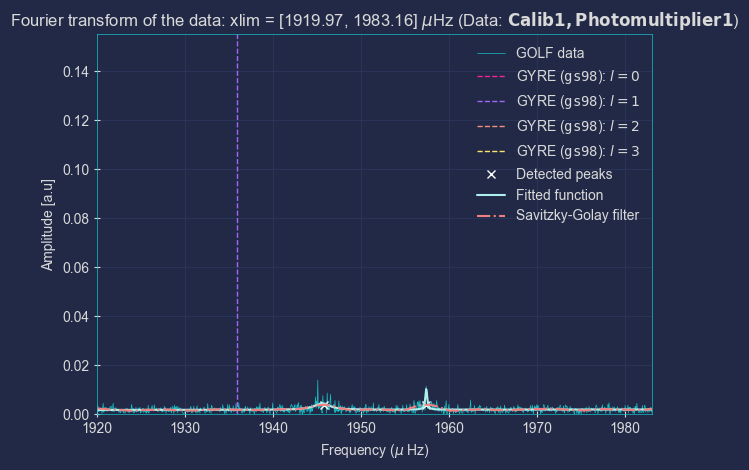

*** Separator ***



MeanY = 0.0021047327483520476. xData_window = [1970.5701542454829, 2033.753374198984].


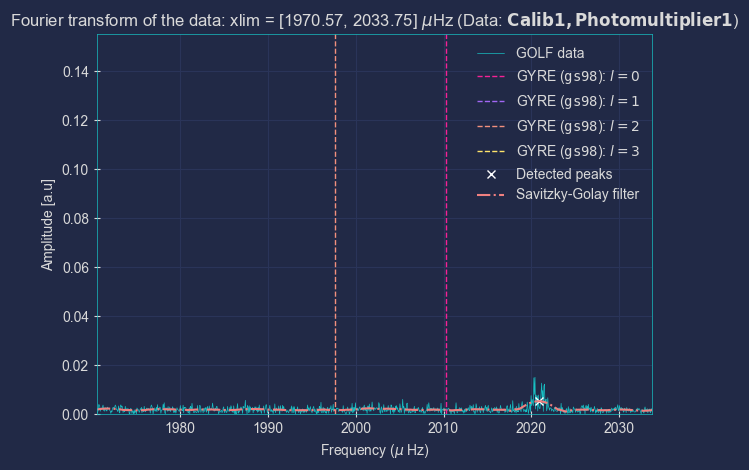

*** Separator ***



Fitting window 2...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = -1.407e-07 ± 2.051e-06, b = 2.177e-03 ± 4.285e-03;
Peak 1: A  = 0.011 ± 0.001, w  = 2.293 ± 0.340, x_0  = 2082.175 ± 0.113;
Peak 2: A1 = 0.006 ± 0.000, w1 = 0.217 ± 0.018, x_01 = 2093.605 ± 0.006.
MeanY = 0.0021538843552329407. xData_window = [2056.0161303787963, 2119.1993503322974].


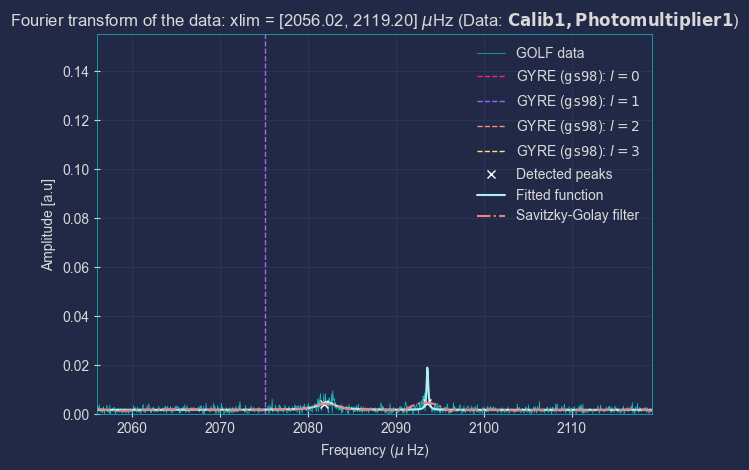

*** Separator ***



MeanY = 0.0022396348250875555. xData_window = [2106.613303514733, 2169.796523468234].


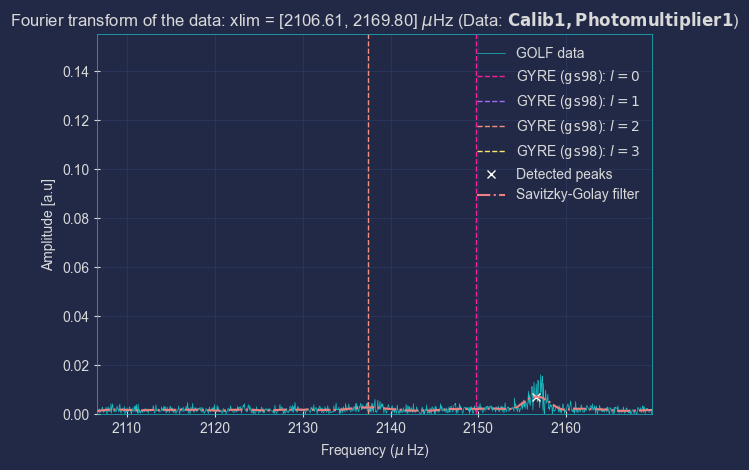

*** Separator ***



Fitting window 4...
Linear off-set: a = -4.719e-06 ± 2.515e-06, b = 1.234e-02 ± 5.594e-03;
Peak 1: A  = 0.020 ± 0.001, w  = 2.008 ± 0.193, x_0  = 2217.921 ± 0.064;
Peak 2: A1 = 0.015 ± 0.001, w1 = 1.068 ± 0.094, x_01 = 2228.795 ± 0.032.
MeanY = 0.002397830327852198. xData_window = [2191.616554383107, 2254.799774336608].


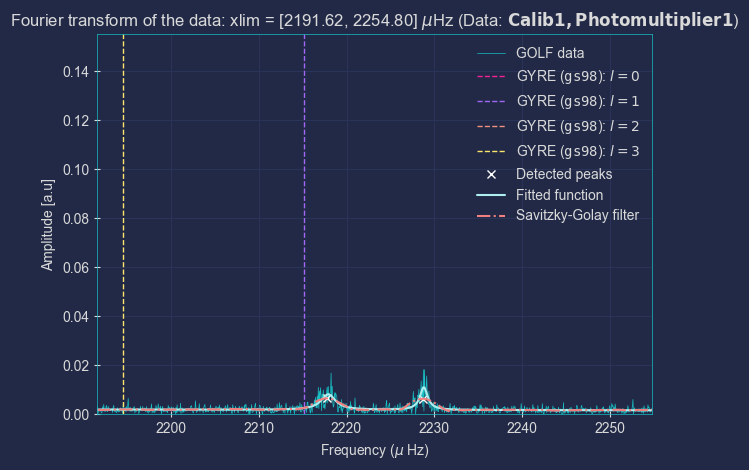

*** Separator ***



Fitting window 5...
Linear off-set: a = 1.082e-06 ± 2.863e-06, b = -6.727e-04 ± 6.538e-03;
Peak 1: A  = 0.010 ± 0.002, w  = 2.883 ± 0.766, x_0  = 2272.522 ± 0.245;
Peak 2: A1 = 0.033 ± 0.002, w1 = 1.844 ± 0.111, x_01 = 2291.888 ± 0.037.
MeanY = 0.002462141891687843. xData_window = [2250.6887540193134, 2313.8719739728144].


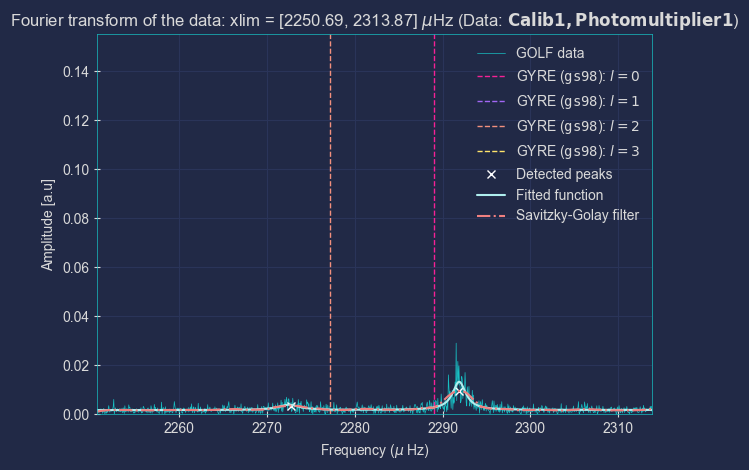

*** Separator ***



Fitting window 6...
Linear off-set: a = -5.780e-08 ± 3.088e-06, b = 2.001e-03 ± 7.281e-03;
Peak 1: A  = 0.035 ± 0.002, w  = 2.263 ± 0.164, x_0  = 2352.098 ± 0.055;
Peak 2: A1 = 0.024 ± 0.001, w1 = 1.519 ± 0.129, x_01 = 2362.756 ± 0.044.
MeanY = 0.0027674970692126. xData_window = [2325.5725702605, 2388.755790214001].


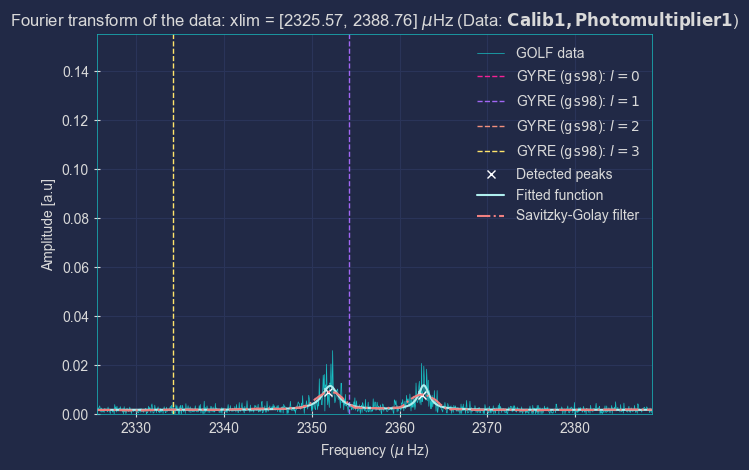

*** Separator ***



Fitting window 7...
Linear off-set: a = -9.383e-07 ± 4.171e-06, b = 4.154e-03 ± 1.008e-02;
Peak 1: A  = 0.012 ± 0.003, w  = 2.322 ± 0.649, x_0  = 2406.986 ± 0.212;
Peak 2: A1 = 0.054 ± 0.002, w1 = 2.015 ± 0.115, x_01 = 2425.577 ± 0.038.
MeanY = 0.002911512812927602. xData_window = [2384.8345092959657, 2448.0177292494673].


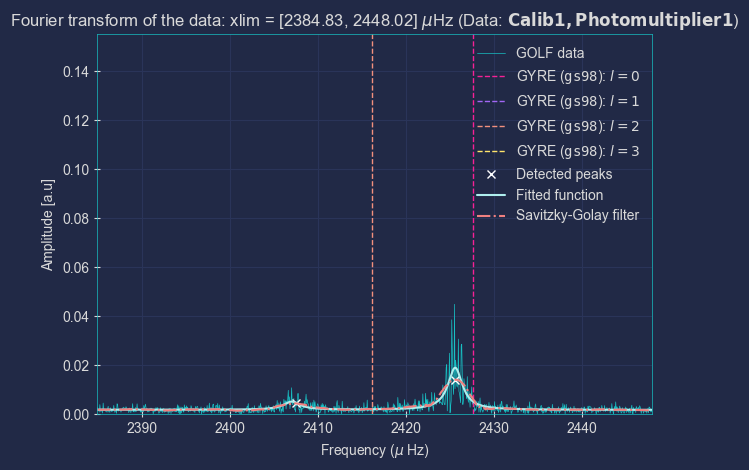

*** Separator ***



Fitting window 8...
Linear off-set: a = -2.023e-06 ± 4.320e-06, b = 6.983e-03 ± 1.076e-02;
Peak 1: A  = 0.052 ± 0.003, w  = 3.119 ± 0.255, x_0  = 2485.902 ± 0.083;
Peak 2: A1 = 0.038 ± 0.002, w1 = 1.548 ± 0.115, x_01 = 2496.066 ± 0.039.
MeanY = 0.003325263887170938. xData_window = [2459.1491073393736, 2522.3323272928747].


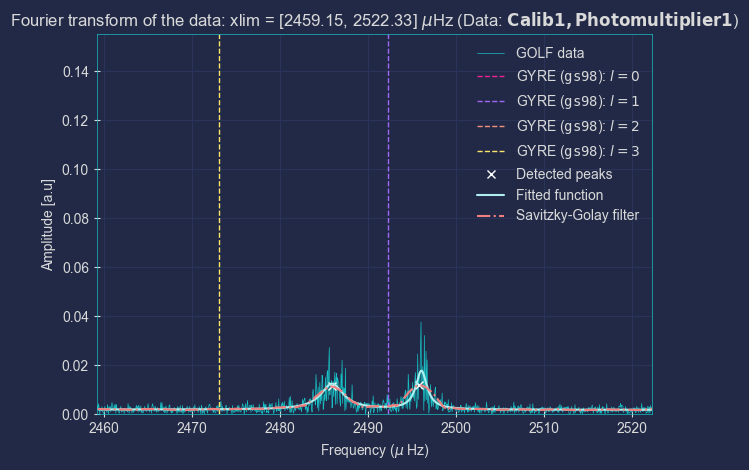

*** Separator ***



Fitting window 9...
Linear off-set: a = -5.263e-07 ± 4.836e-06, b = 3.219e-03 ± 1.234e-02;
Peak 1: A  = 0.018 ± 0.004, w  = 3.774 ± 1.067, x_0  = 2541.582 ± 0.334;
Peak 2: A1 = 0.082 ± 0.003, w1 = 2.263 ± 0.104, x_01 = 2559.283 ± 0.034.
MeanY = 0.003417174703689464. xData_window = [2518.4742928412593, 2581.6575127947604].


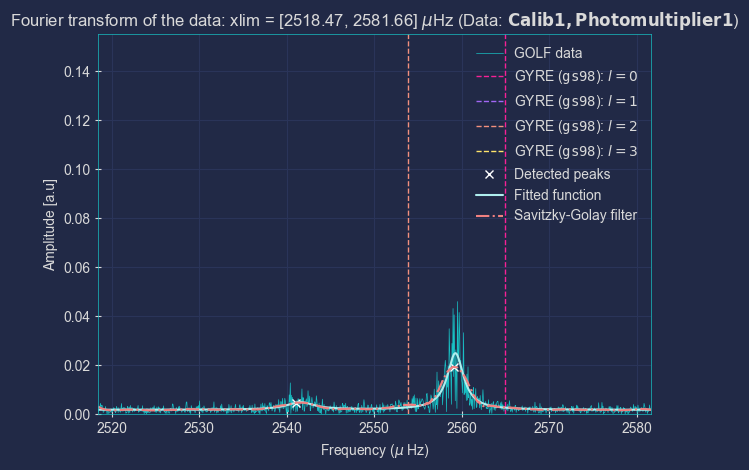

*** Separator ***



Fitting window 10...
Linear off-set: a = -1.817e-06 ± 4.618e-06, b = 6.688e-03 ± 1.212e-02;
Peak 1: A  = 0.068 ± 0.004, w  = 3.359 ± 0.230, x_0  = 2619.684 ± 0.074;
Peak 2: A1 = 0.061 ± 0.003, w1 = 1.970 ± 0.111, x_01 = 2629.827 ± 0.037.
MeanY = 0.0039088538184947575. xData_window = [2593.1683696831865, 2656.3515896366875].


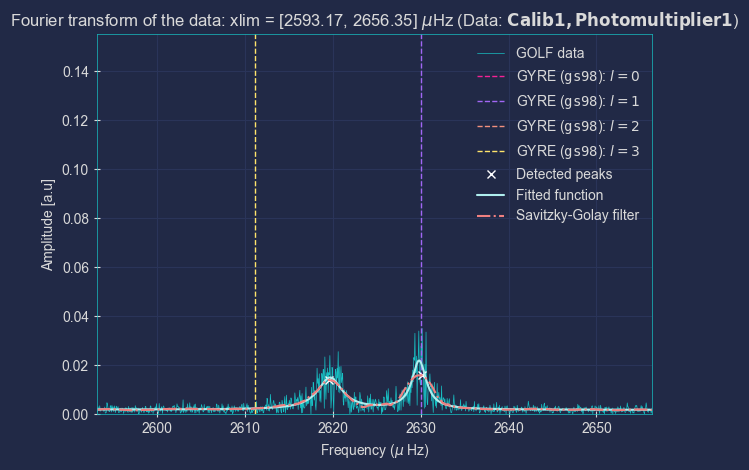

*** Separator ***



Fitting window 11...
Linear off-set: a = -6.089e-06 ± 6.547e-06, b = 1.805e-02 ± 1.759e-02;
Peak 1: A  = 0.032 ± 0.006, w  = 4.199 ± 0.955, x_0  = 2675.964 ± 0.295;
Peak 2: A1 = 0.131 ± 0.004, w1 = 2.346 ± 0.093, x_01 = 2693.314 ± 0.030.
MeanY = 0.004215464364376417. xData_window = [2652.9995269164315, 2716.182746869933].


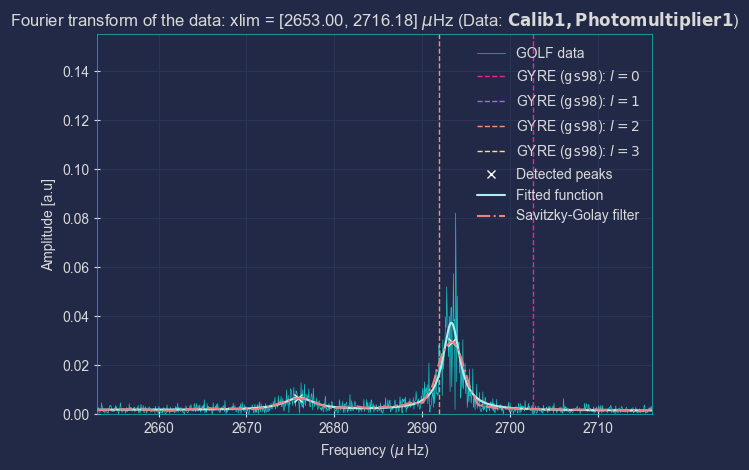

*** Separator ***



Fitting window 12...
Linear off-set: a = -3.939e-06 ± 6.154e-06, b = 1.273e-02 ± 1.699e-02;
Peak 1: A  = 0.098 ± 0.005, w  = 3.726 ± 0.253, x_0  = 2754.612 ± 0.081;
Peak 2: A1 = 0.082 ± 0.004, w1 = 2.251 ± 0.137, x_01 = 2764.189 ± 0.045.
MeanY = 0.0046169059001013. xData_window = [2727.6303572919387, 2790.81357724544].


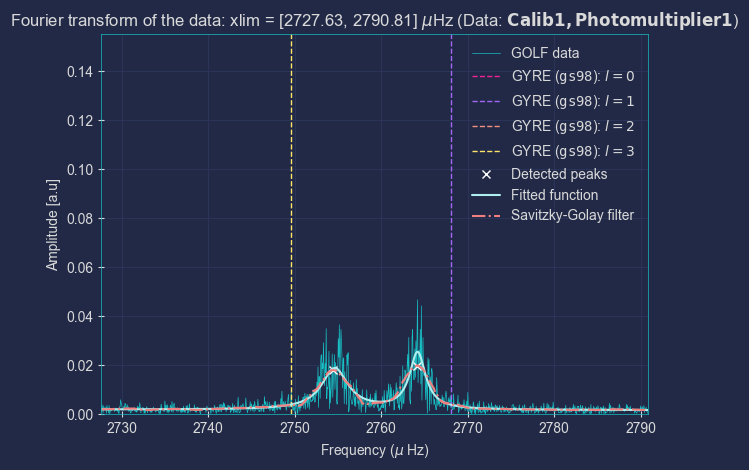

*** Separator ***



Fitting window 13...
Linear off-set: a = 2.068e-06 ± 7.713e-06, b = -3.676e-03 ± 2.176e-02;
Peak 1: A  = 0.040 ± 0.007, w  = 3.835 ± 0.787, x_0  = 2811.334 ± 0.246;
Peak 2: A1 = 0.141 ± 0.005, w1 = 2.334 ± 0.102, x_01 = 2828.080 ± 0.033.
MeanY = 0.004944565120598675. xData_window = [2787.9042397901235, 2851.0874597436245].


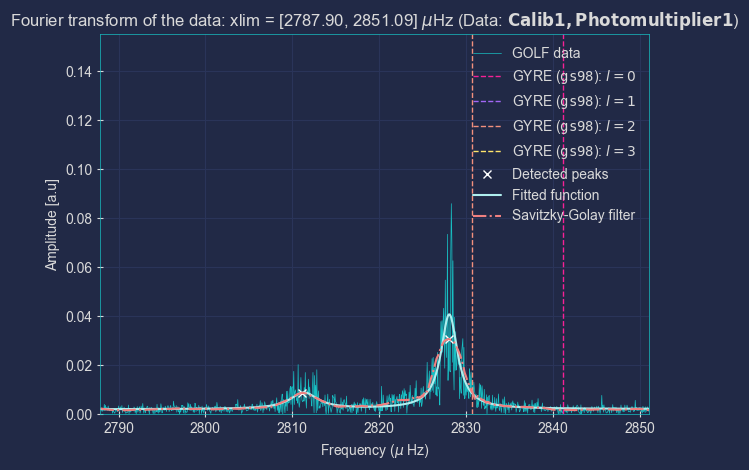

*** Separator ***



Fitting window 14...
Linear off-set: a = -7.057e-06 ± 8.329e-06, b = 2.281e-02 ± 2.411e-02;
Peak 1: A  = 0.111 ± 0.006, w  = 2.611 ± 0.173, x_0  = 2889.852 ± 0.057;
Peak 2: A1 = 0.093 ± 0.004, w1 = 1.635 ± 0.099, x_01 = 2898.846 ± 0.034.
MeanY = 0.0055408278414416584. xData_window = [2862.5350701656307, 2925.7182901191313].


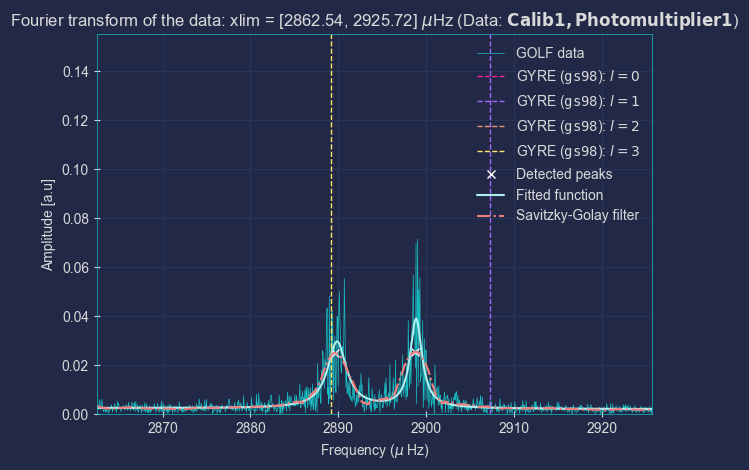

*** Separator ***



Fitting window 15...
Linear off-set: a = 4.905e-06 ± 1.043e-05, b = -1.218e-02 ± 3.085e-02;
Peak 1: A  = 0.059 ± 0.009, w  = 4.065 ± 0.794, x_0  = 2947.208 ± 0.247;
Peak 2: A1 = 0.186 ± 0.006, w1 = 2.330 ± 0.104, x_01 = 2963.654 ± 0.034.
MeanY = 0.006081225449312198. xData_window = [2923.6944031936937, 2986.877623147195].


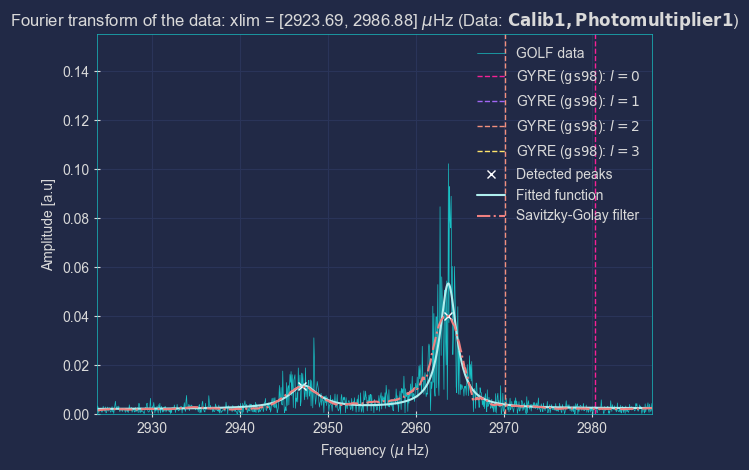

*** Separator ***



Fitting window 16...
Linear off-set: a = 3.216e-06 ± 9.837e-06, b = -6.444e-03 ± 2.981e-02;
Peak 1: A  = 0.164 ± 0.007, w  = 3.129 ± 0.184, x_0  = 3024.432 ± 0.060;
Peak 2: A1 = 0.064 ± 0.003, w1 = 0.554 ± 0.033, x_01 = 3033.620 ± 0.011.
MeanY = 0.006814445776443906. xData_window = [2997.5662759721617, 3060.7494959256633].


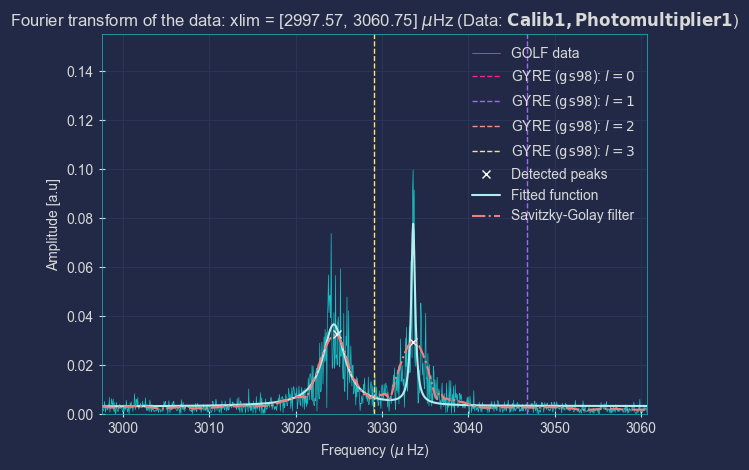

*** Separator ***



Fitting window 17...
Linear off-set: a = -2.228e-07 ± 1.114e-05, b = 2.799e-03 ± 3.443e-02;
Peak 1: A  = 0.063 ± 0.009, w  = 3.635 ± 0.667, x_0  = 3081.793 ± 0.210;
Peak 2: A1 = 0.224 ± 0.008, w1 = 3.090 ± 0.144, x_01 = 3098.025 ± 0.046.
MeanY = 0.006491232917369867. xData_window = [3058.1563908024464, 3121.3396107559474].


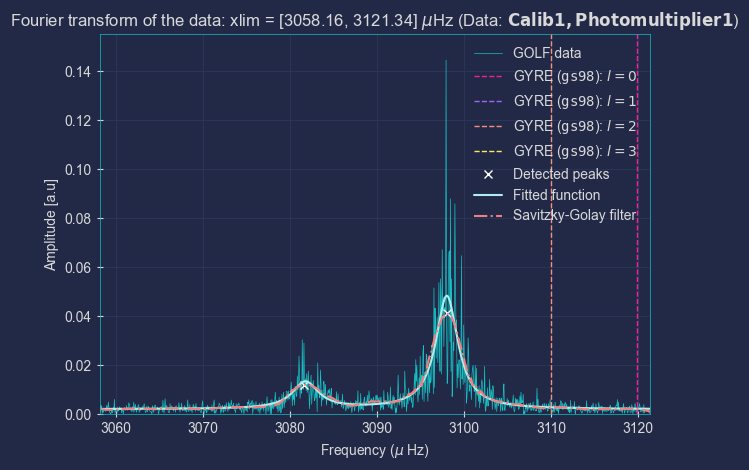

*** Separator ***



Fitting window 18...
Linear off-set: a = -6.609e-06 ± 1.130e-05, b = 2.359e-02 ± 3.575e-02;
Peak 1: A  = 0.155 ± 0.010, w  = 4.161 ± 0.353, x_0  = 3159.756 ± 0.111;
Peak 2: A1 = 0.149 ± 0.006, w1 = 1.663 ± 0.087, x_01 = 3168.658 ± 0.029.
MeanY = 0.007340787403956053. xData_window = [3132.4709888458538, 3195.654208799355].


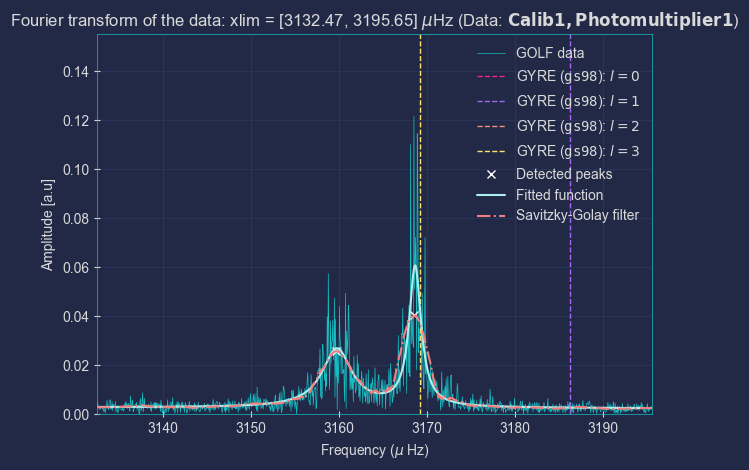

*** Separator ***



Fitting window 19...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 4.825e-06 ± 1.210e-05, b = -1.305e-02 ± 3.905e-02;
Peak 1: A  = 0.073 ± 0.012, w  = 4.568 ± 0.903, x_0  = 3218.108 ± 0.278;
Peak 2: A1 = 0.248 ± 0.009, w1 = 3.127 ± 0.143, x_01 = 3233.377 ± 0.046.
MeanY = 0.00740094865728861. xData_window = [3193.946554206017, 3257.129774159518].


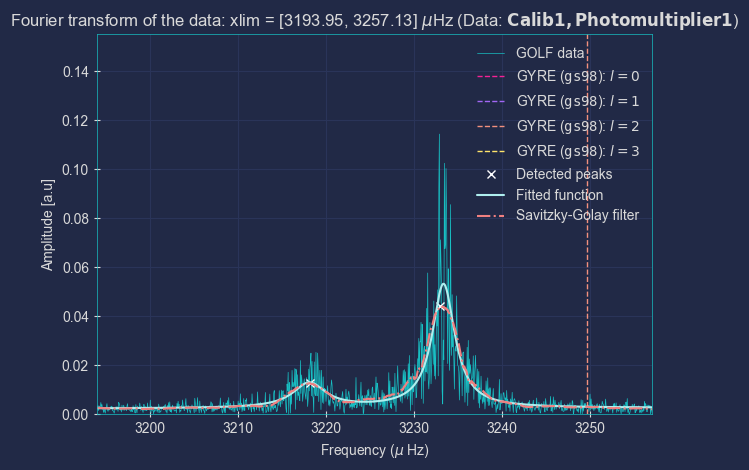

*** Separator ***



Fitting window 20...
Linear off-set: a = -7.250e-06 ± 1.122e-05, b = 2.668e-02 ± 3.702e-02;
Peak 1: A  = 0.180 ± 0.010, w  = 3.679 ± 0.252, x_0  = 3295.134 ± 0.079;
Peak 2: A1 = 0.149 ± 0.007, w1 = 2.360 ± 0.150, x_01 = 3303.173 ± 0.049.
MeanY = 0.007795686231755507. xData_window = [3267.691934051645, 3330.875154005146].


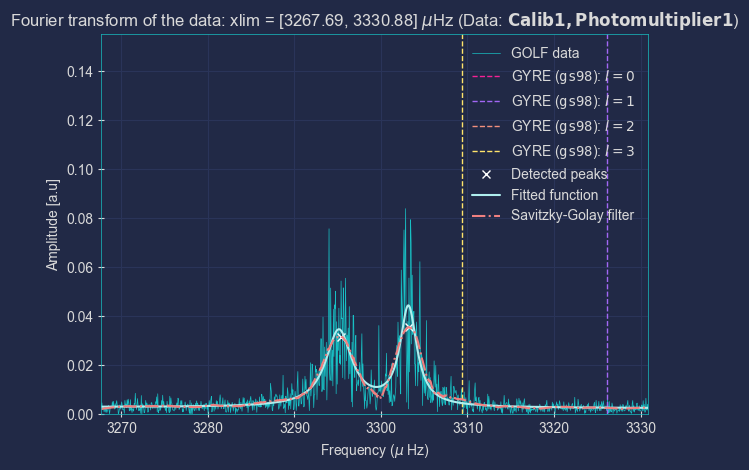

*** Separator ***



Fitting window 21...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 7.917e-06 ± 9.934e-06, b = -2.383e-02 ± 3.342e-02;
Peak 1: A  = 0.063 ± 0.012, w  = 6.019 ± 1.338, x_0  = 3354.317 ± 0.396;
Peak 2: A1 = 0.206 ± 0.007, w1 = 3.132 ± 0.141, x_01 = 3368.751 ± 0.045.
MeanY = 0.006866095681094667. xData_window = [3329.6734711431677, 3392.8566910966692].


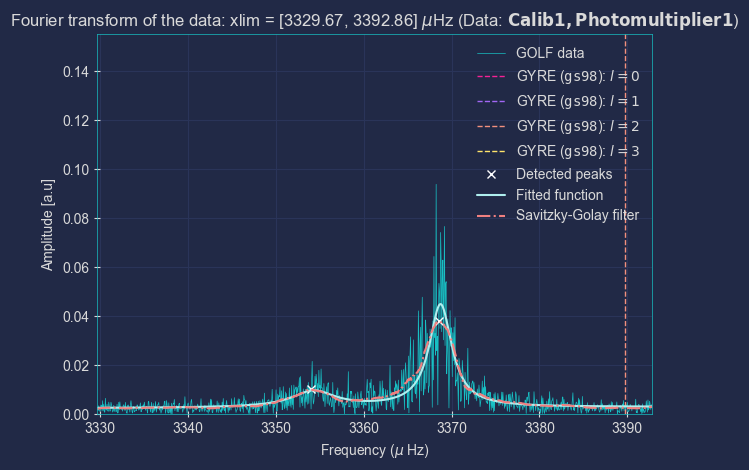

*** Separator ***



Fitting window 22...
Linear off-set: a = -1.145e-05 ± 9.363e-06, b = 4.215e-02 ± 3.217e-02;
Peak 1: A  = 0.173 ± 0.009, w  = 4.066 ± 0.263, x_0  = 3430.889 ± 0.081;
Peak 2: A1 = 0.149 ± 0.008, w1 = 3.308 ± 0.218, x_01 = 3438.927 ± 0.068.
MeanY = 0.0076983663935993206. xData_window = [3403.229111589536, 3466.4123315430375].


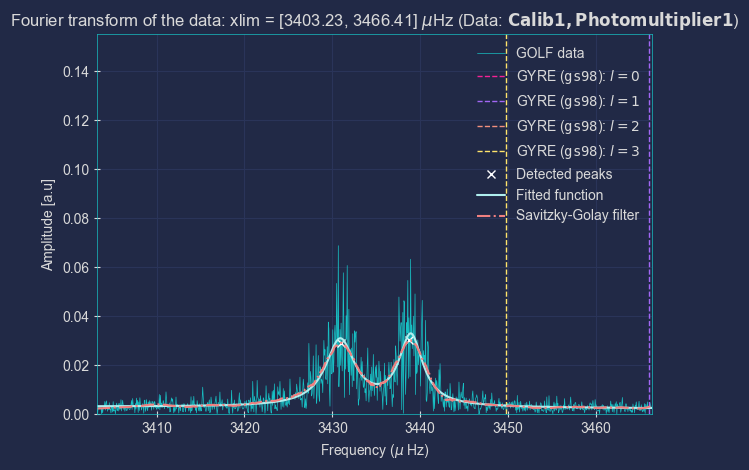

*** Separator ***



Fitting window 23...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = 8.254e-06 ± 1.064e-05, b = -2.618e-02 ± 3.724e-02;
Peak 1: A  = 0.062 ± 0.016, w  = 8.126 ± 2.417, x_0  = 3490.036 ± 0.669;
Peak 2: A1 = 0.220 ± 0.010, w1 = 4.530 ± 0.254, x_01 = 3503.711 ± 0.077.
MeanY = 0.006888624876839657. xData_window = [3464.5781840168593, 3527.7614039703603].


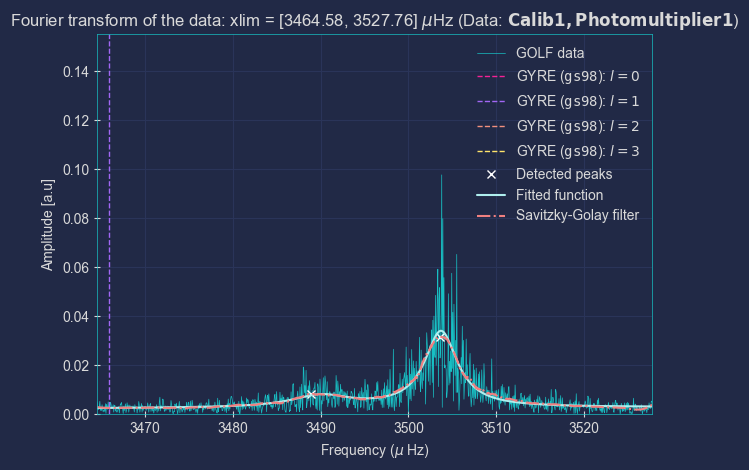

*** Separator ***



Fitting window 24...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = -4.696e-06 ± 8.297e-06, b = 1.950e-02 ± 2.965e-02;
Peak 1: A  = 0.173 ± 0.016, w  = 7.348 ± 0.711, x_0  = 3566.698 ± 0.202;
Peak 2: A1 = 0.120 ± 0.012, w1 = 4.834 ± 0.495, x_01 = 3574.727 ± 0.142.
MeanY = 0.007074257631264709. xData_window = [3539.019274993107, 3602.202494946608].


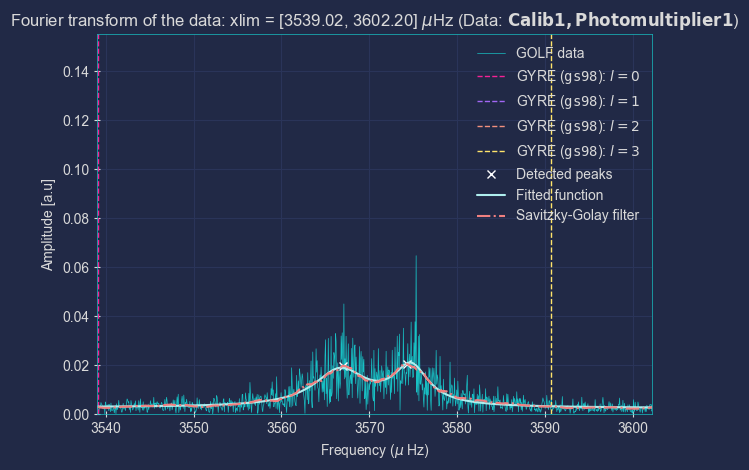

*** Separator ***



MeanY = 0.006481528943797701. xData_window = [3589.616448129044, 3652.799668082545].


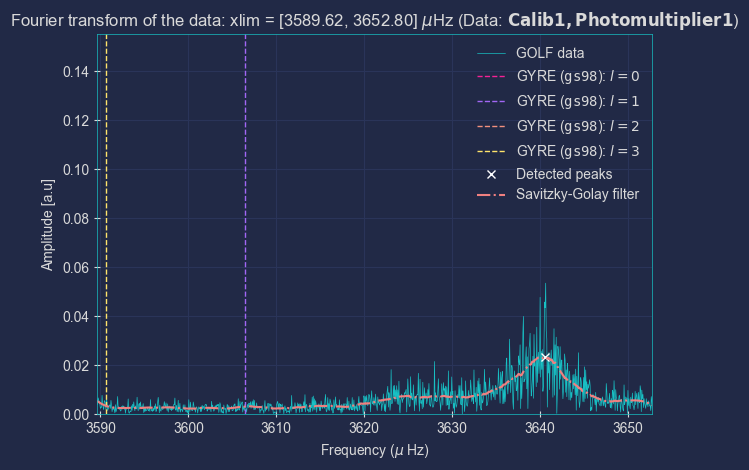

*** Separator ***



Fitting window 26...
No MESA radial modes (detected) in the current window. [Check results manually...]
Linear off-set: a = -1.342e-05 ± 7.934e-06, b = 5.205e-02 ± 2.934e-02;
Peak 1: A  = 0.079 ± 0.015, w  = 4.715 ± 0.773, x_0  = 3702.007 ± 0.202;
Peak 2: A1 = 0.240 ± 0.027, w1 = 10.807 ± 1.103, x_01 = 3709.852 ± 0.327.
MeanY = 0.0068877058888216144. xData_window = [3673.923987866798, 3737.1072078202997].


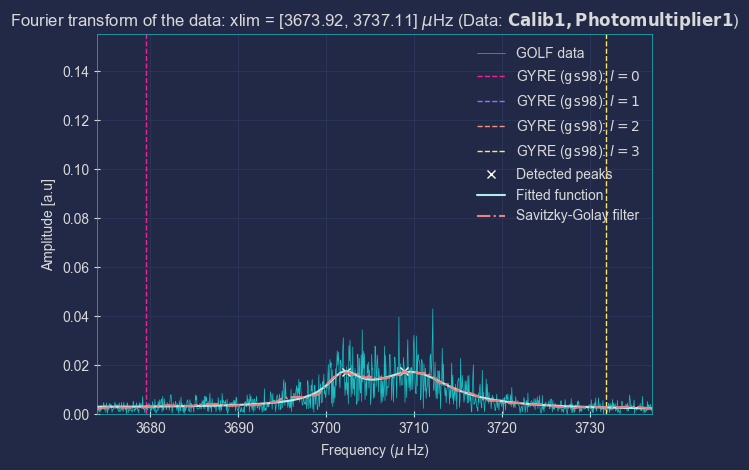

*** Separator ***



MeanY = 0.006174341504953717. xData_window = [3724.521161002735, 3787.7043809562365].


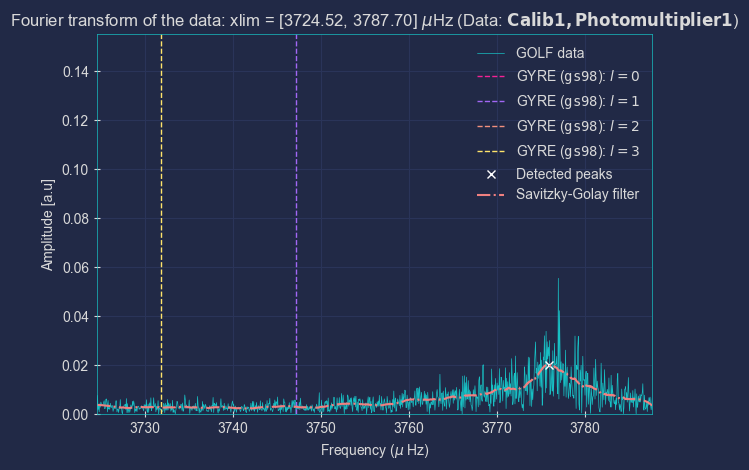

*** Separator ***



MeanY = 0.005567849945817599. xData_window = [3775.1183341386723, 3838.3015540921733].


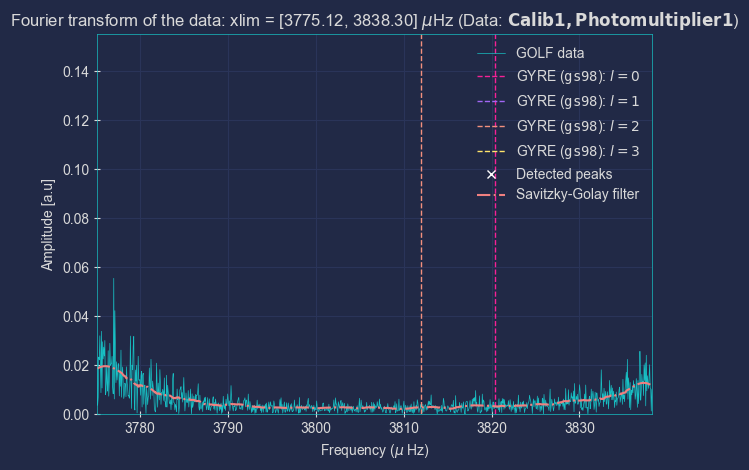

*** Separator ***



MeanY = 0.005392643638109401. xData_window = [3851.0140938425775, 3914.197313796079].


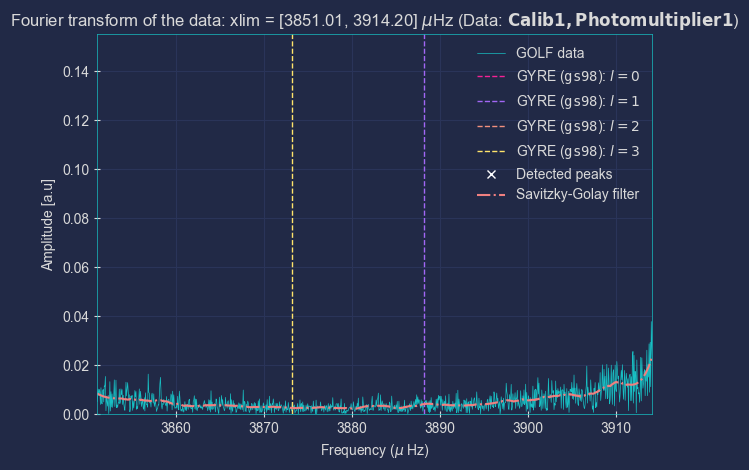

*** Separator ***



Fitting window 30...
Linear off-set: a = -1.886e-05 ± 6.186e-06, b = 7.713e-02 ± 2.456e-02;
Peak 1: A  = 0.007 ± 0.003, w  = 1.018 ± 0.478, x_0  = 3974.654 ± 0.144;
Peak 2: A1 = 0.266 ± 0.025, w1 = 17.299 ± 1.448, x_01 = 3982.615 ± 0.343.
MeanY = 0.005655188154851778. xData_window = [3948.0341733307364, 4011.217393284238].


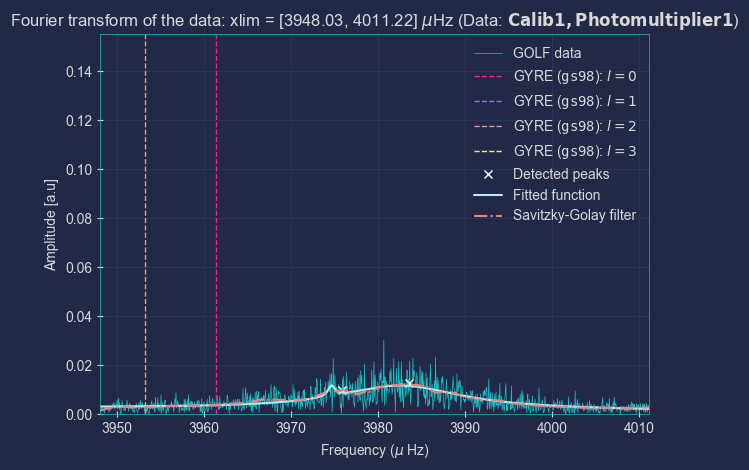

*** Separator ***



MeanY = 0.005409727170657651. xData_window = [3998.6313464666737, 4061.814566420175].


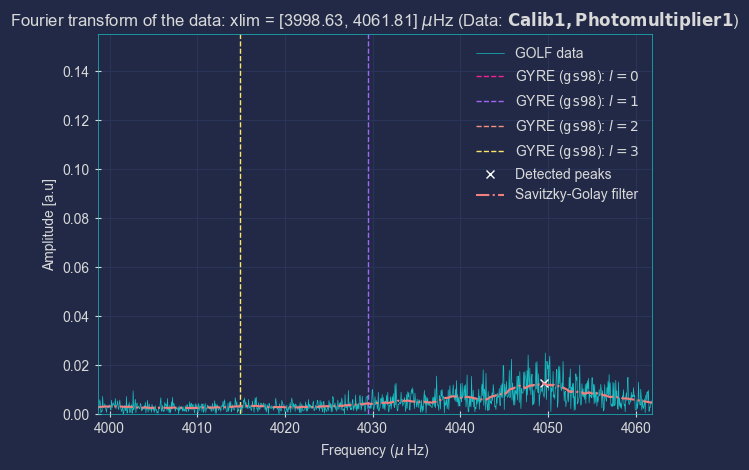

*** Separator ***



MeanY = 0.004955751456298721. xData_window = [4049.22851960261, 4112.411739556112].


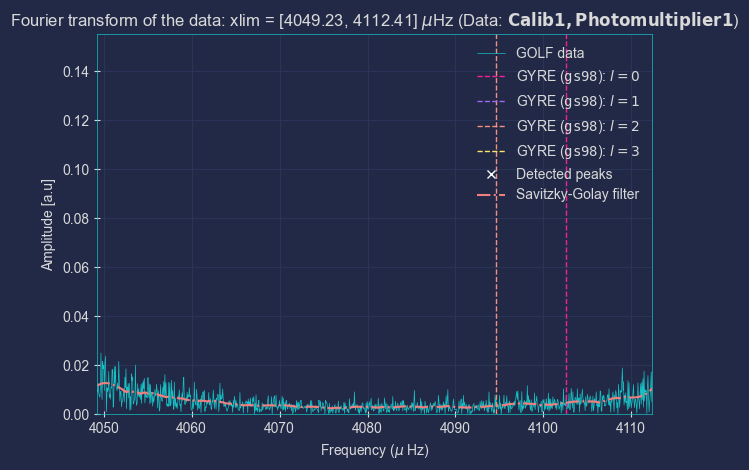

*** Separator ***



MeanY = 0.005441971998188597. xData_window = [4080.851752812571, 4144.034972766072].


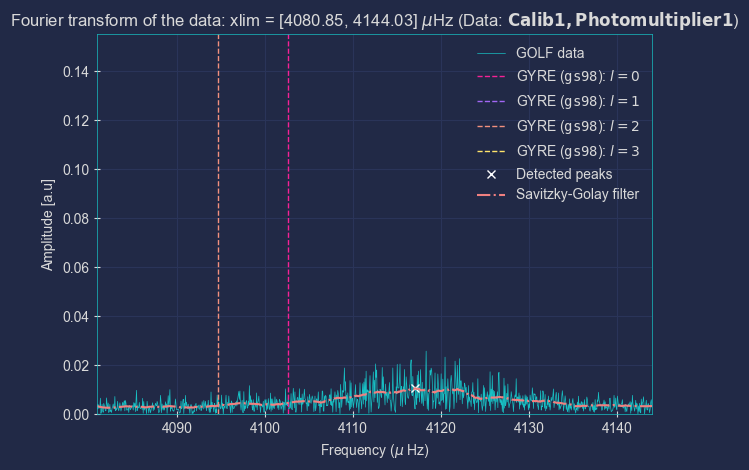

*** Separator ***



MeanY = 0.005121475320478467. xData_window = [4131.448925948508, 4194.632145902009].


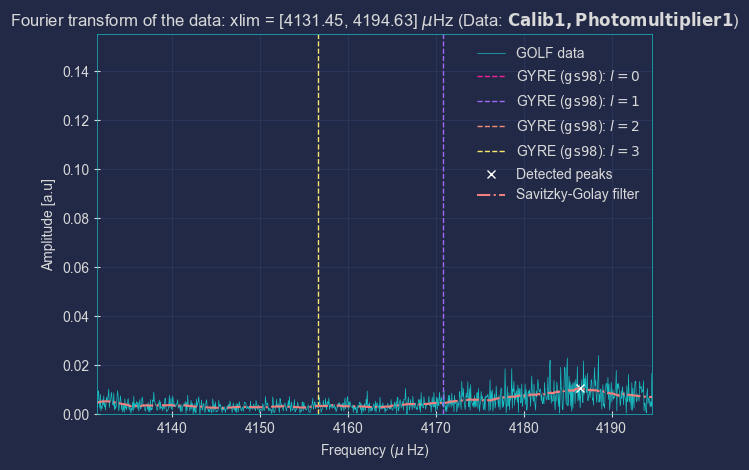

*** Separator ***



MeanY = 0.004936442477570535. xData_window = [4182.046099084445, 4245.229319037946].


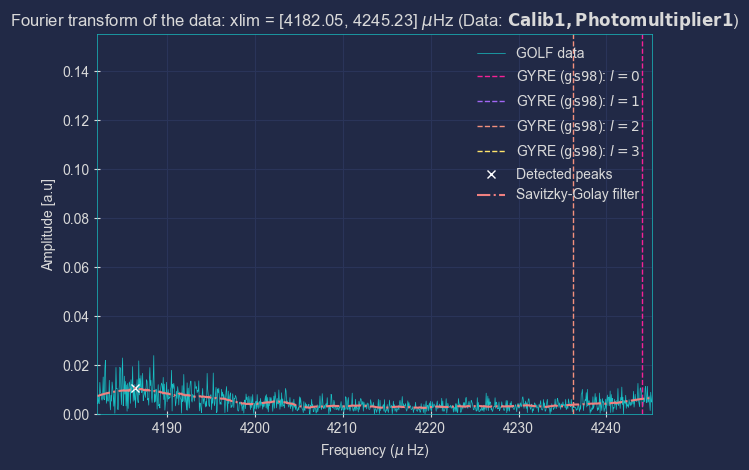

*** Separator ***



MeanY = 0.004507886942646018. xData_window = [4257.94185878835, 4321.125078741851].


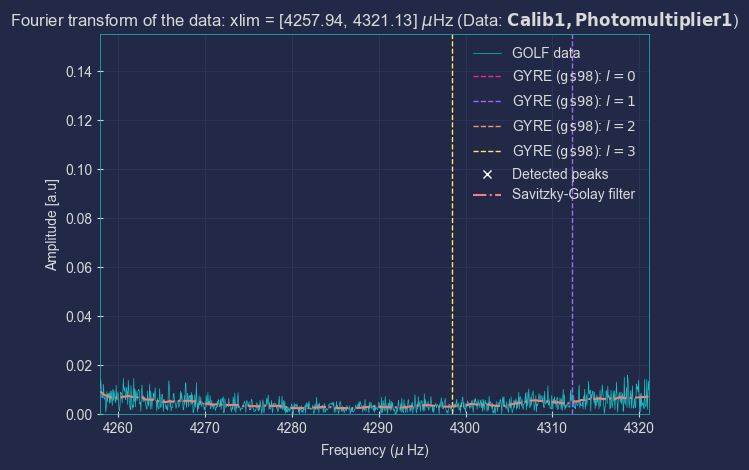

*** Separator ***



MeanY = 0.004878567740622091. xData_window = [4308.539031924287, 4371.722251877788].


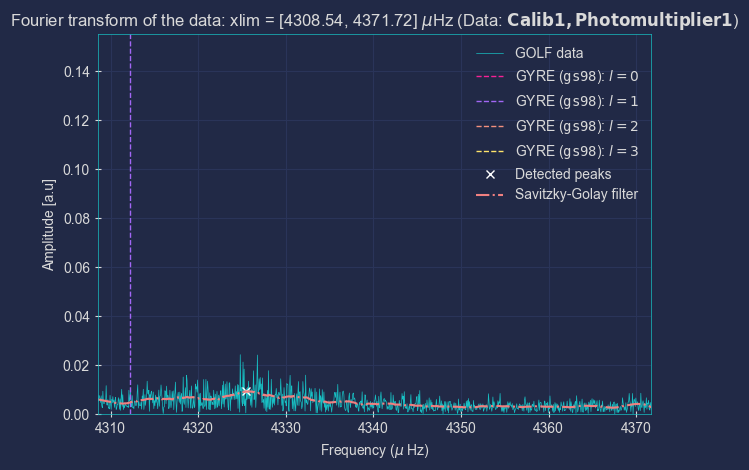

*** Separator ***



MeanY = 0.004678355518300025. xData_window = [4359.136205060224, 4422.319425013725].


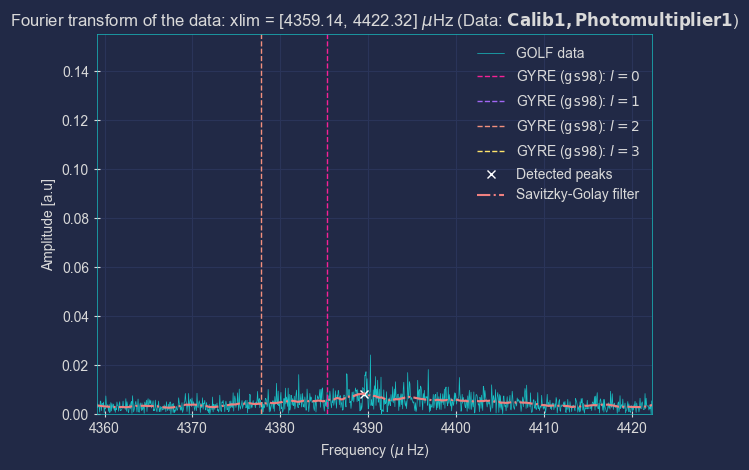

*** Separator ***



MeanY = 0.00456828174020849. xData_window = [4409.733378196161, 4472.916598149662].


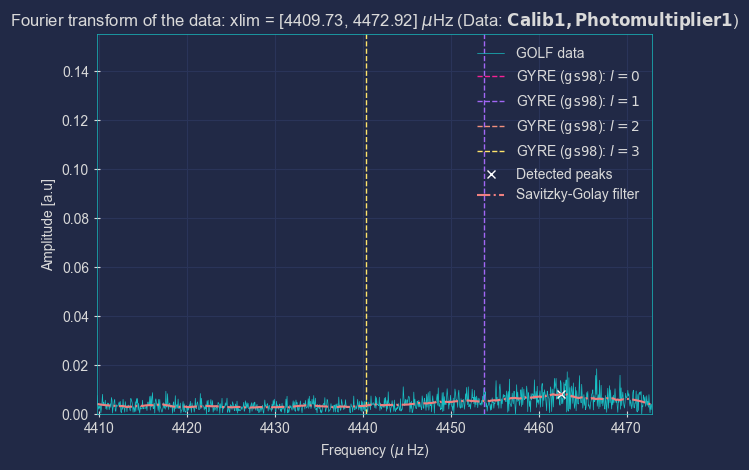

*** Separator ***



MeanY = 0.004373138562640973. xData_window = [4460.3305513320975, 4523.5137712855985].


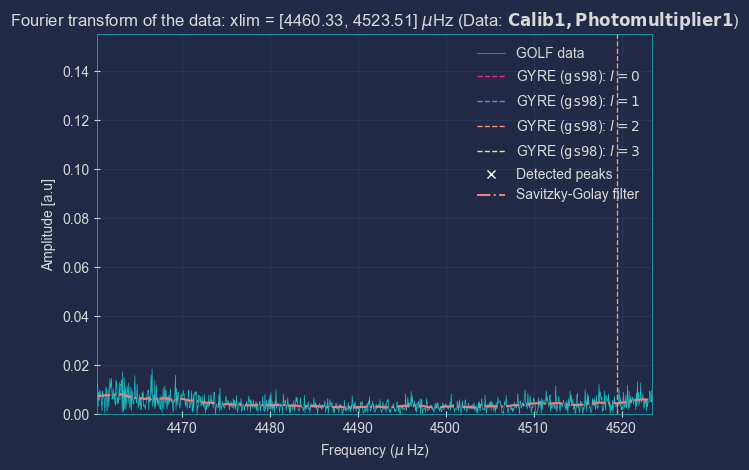

*** Separator ***



MeanY = 0.004465327277325364. xData_window = [4510.927724468034, 4574.110944421536].


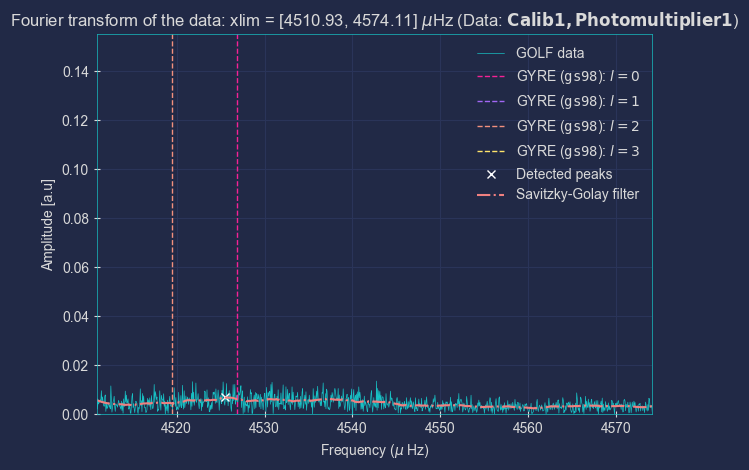

*** Separator ***



MeanY = 0.004429237477002708. xData_window = [4561.524897603971, 4624.708117557472].


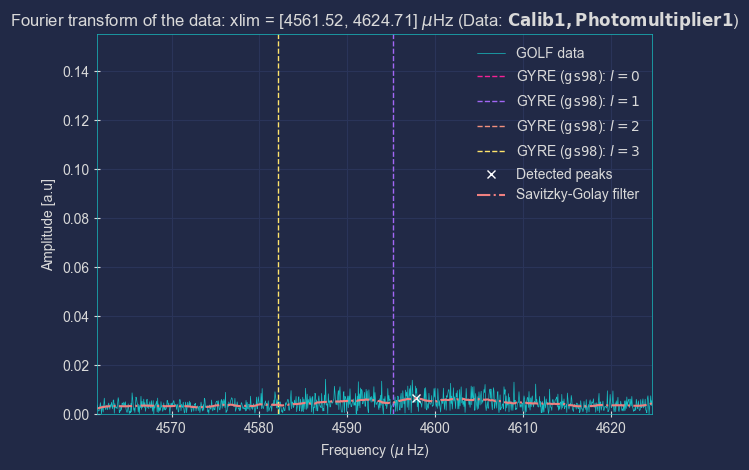

*** Separator ***



Fitting window 43...
Linear off-set: a = -5.351e-07 ± 4.105e-06, b = 6.771e-03 ± 1.917e-02;
Peak 1: A  = 0.004 ± 0.001, w  = 0.373 ± 0.135, x_0  = 4660.462 ± 0.047;
Peak 2: A1 = 0.001 ± 0.000, w1 = 0.083 ± 0.043, x_01 = 4678.903 ± 0.026.
MeanY = 0.004348524852381105. xData_window = [4637.357410841457, 4700.540630794959].


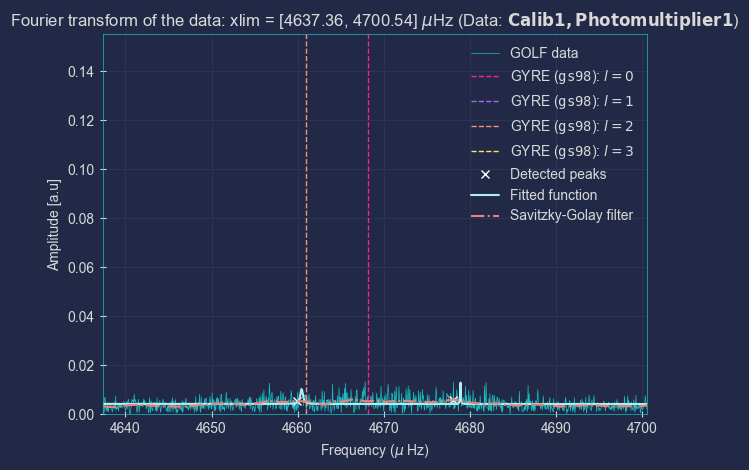

*** Separator ***



MeanY = 0.004098702240703868. xData_window = [4687.954583977394, 4751.137803930895].


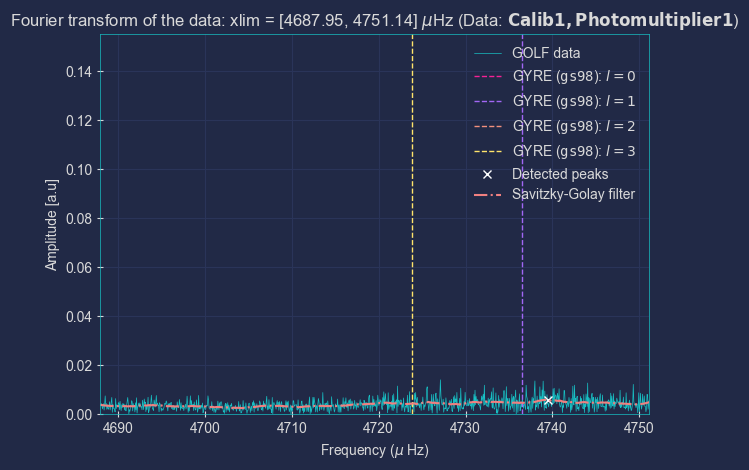

*** Separator ***



MeanY = 0.003966022618241076. xData_window = [4751.201050397315, 4814.384270350816].


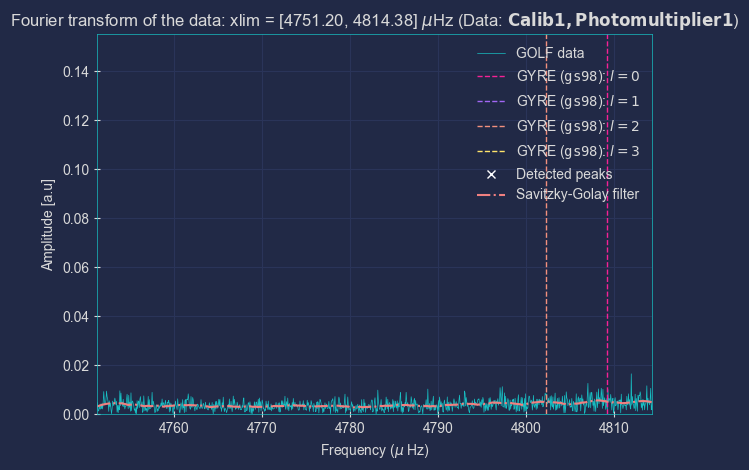

*** Separator ***



MeanY = 0.00380636547359432. xData_window = [4814.447516817236, 4877.630736770738].


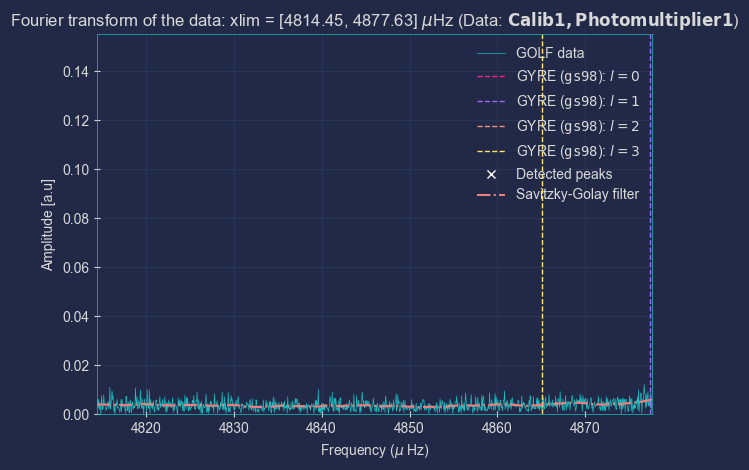

*** Separator ***



MeanY = 0.003713055835119592. xData_window = [4877.693983237157, 4940.877203190658].


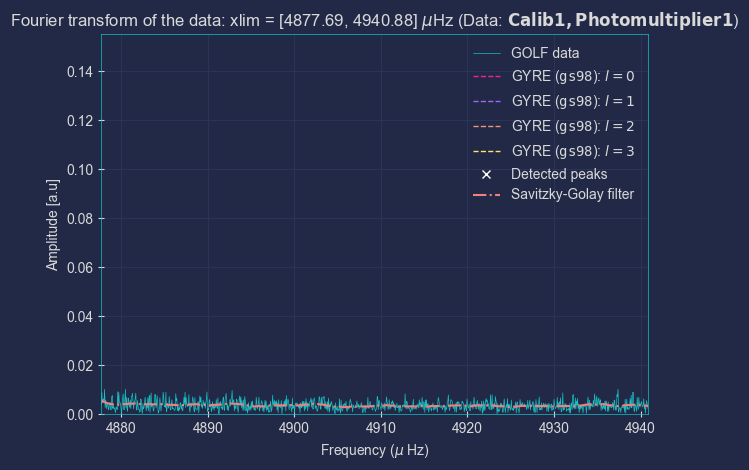

*** Separator ***



MeanY = 0.0037405377254997436. xData_window = [4940.940449657079, 5004.12366961058].


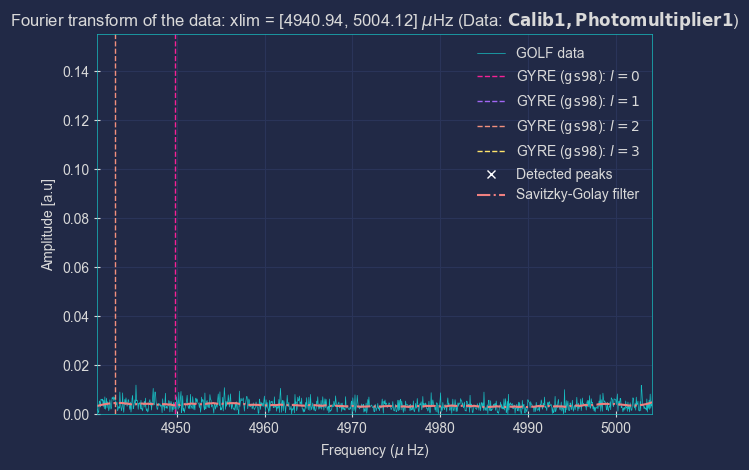

*** Separator ***



MeanY = 0.0036322673066975807. xData_window = [5004.186916076999, 5067.370136030501].


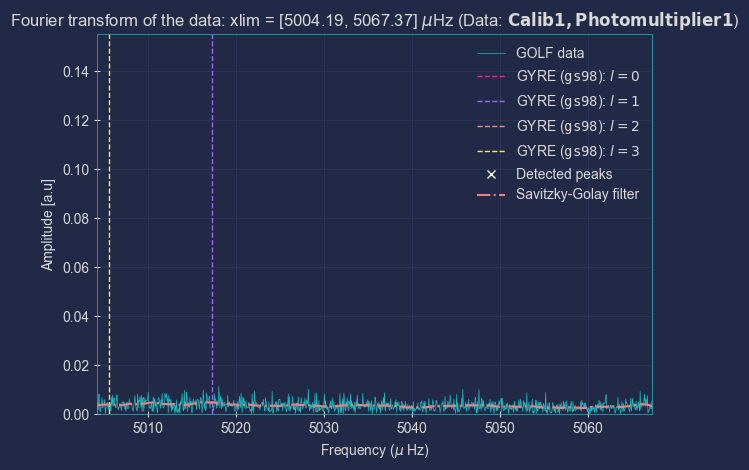

*** Separator ***



MeanY = 0.0034290396862583722. xData_window = [5080.0826757809045, 5143.2658957344065].


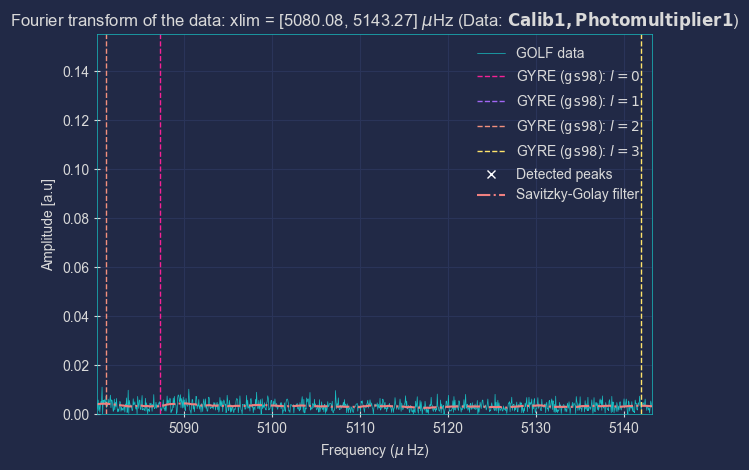

In [530]:
xAll, yAll = xf*1e6, 2.0/N * np.abs(y11f[:N//2])
test_obj = Progressive_Lorentz_Fitter(xAll, yAll, \
                                      l0, l1, l2, l3, \
                                      itSkip = 30, window_size = 1000) # ~63 uHz window size!
test_obj.fit_window()
test_obj.plot_window()
print('*** Separator ***\n\n\n')

for i in range(50):
    test_obj.advance_window()
    test_obj.fit_window()
    test_obj.plot_window()
    if(i != 49): print('*** Separator ***\n\n\n')

[MESA/GYRE] Average large separation (Sun) = 134.61693311687262 uHz.
[MESA/GYRE] Average small separation (Sun) = 79.82954716281971 uHz.


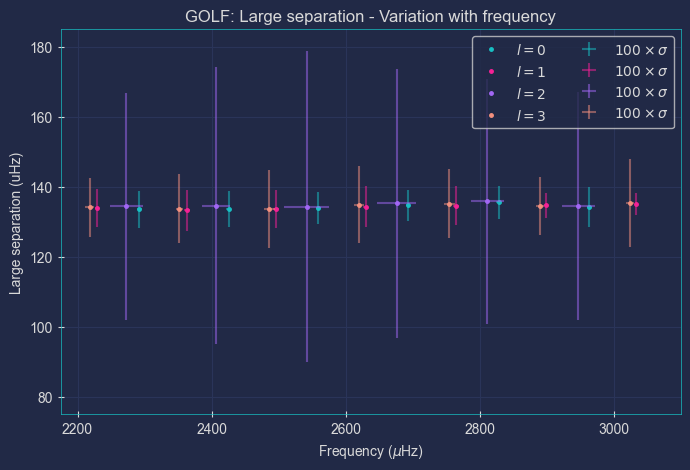

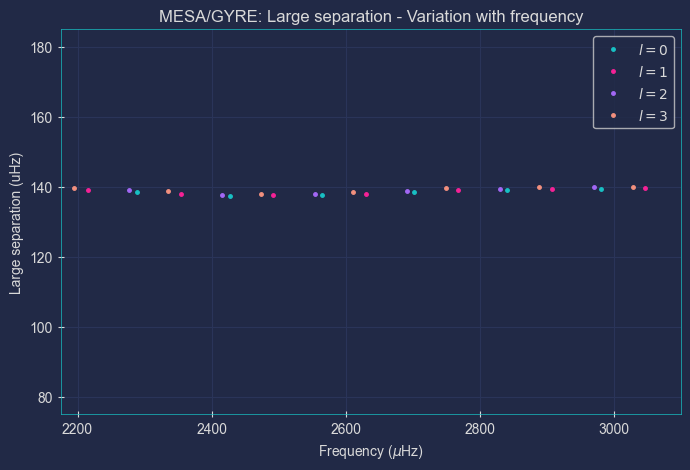

Average large separation: l0 = 134.356 uHz, l1 = 134.459, l2 = 134.879, l3 = 134.774 (GOLF).
Average large separation: l0 = 141.102 uHz, l1 = 141.183, l2 = 141.139, l3 = 141.340 (MESA/GYRE).


In [511]:
df = pd.DataFrame(test_obj.freqs, columns = ['Re(freq)', 'Re(freq)_Err', 'l', 'n_p'])
Freqs_GOLF_obj = Stellar_freqs(df)
print(Freqs_GOLF_obj) # Debugging aid

# Large separation plots
large_l0_GOLF, large_l1_GOLF, large_l2_GOLF, large_l3_GOLF = \
    Freqs_GOLF_obj.large_sep_plot(xlim = (2.175e3, 3.1e3), ylim = (75, 185), title = 'GOLF: Large separation - Variation with frequency', append_name = 'GOLF')
large_l0_MESA, large_l1_MESA, large_l2_MESA, large_l3_MESA = \
    Freqs_MESA_obj.large_sep_plot(xlim = (2.175e3, 3.1e3), ylim = (75, 185), title = 'MESA/GYRE: Large separation - Variation with frequency', append_name = 'MESA_detail')

# Comparing the large separations
print(f'Average large separation: l0 = {np.mean([freq[0] for freq in large_l0_GOLF]):.3f} uHz, \
l1 = {np.mean([freq[0] for freq in large_l1_GOLF]):.3f}, l2 = {np.mean([freq[0] for freq in large_l2_GOLF]):.3f}, \
l3 = {np.mean([freq[0] for freq in large_l3_GOLF]):.3f} (GOLF).')
print(f'Average large separation: l0 = {np.mean([freq[0] for freq in large_l0_MESA]):.3f} uHz, \
l1 = {np.mean([freq[0] for freq in large_l1_MESA]):.3f}, l2 = {np.mean([freq[0] for freq in large_l2_MESA]):.3f}, \
l3 = {np.mean([freq[0] for freq in large_l3_MESA]):.3f} (MESA/GYRE).')

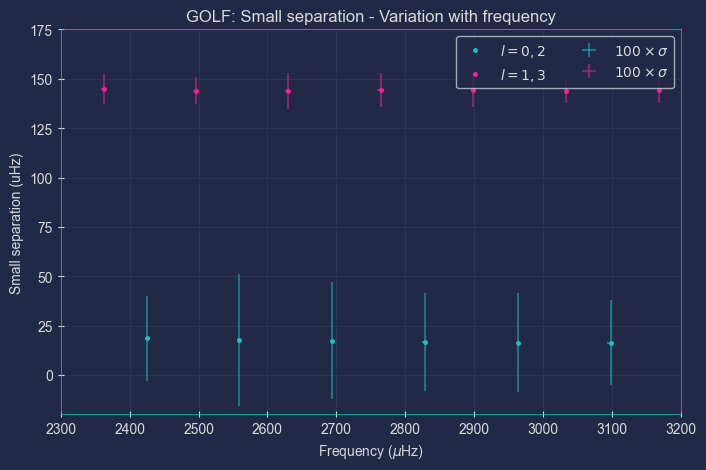

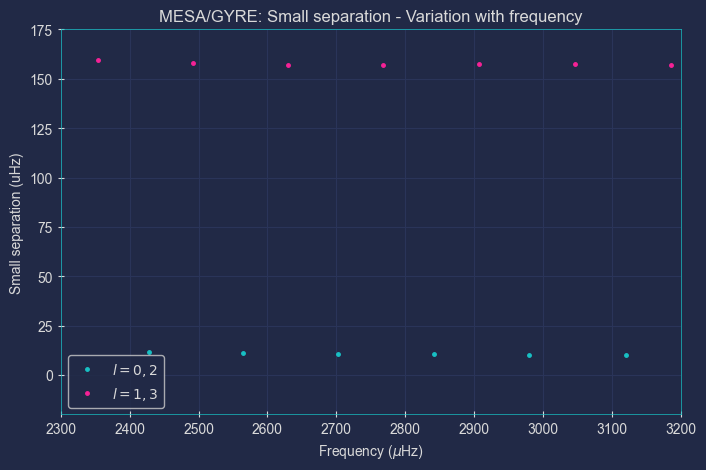

Average small separation: l0,2 = 15.585 uHz, l1,3 = 144.074 uHz (GOLF).
Average small separation: l0,2 = 1.999 uHz, l1,3 = 144.626 uHz (MESA/GYRE).


In [512]:
# Small separation plots
small_l0_GOLF, small_l1_GOLF = Freqs_GOLF_obj.small_sep_plot(xlim = (2.3e3, 3.2e3), ylim = (-20, 175), title = 'GOLF: Small separation - Variation with frequency', append_name = 'GOLF')
small_l0_MESA, small_l1_MESA = Freqs_MESA_obj.small_sep_plot(xlim = (2.3e3, 3.2e3), ylim = (-20, 175), title = 'MESA/GYRE: Small separation - Variation with frequency', append_name = 'MESA_detail')

# Comparing the small separations
print(f'Average small separation: l0,2 = {np.mean([freq[0] for freq in small_l0_GOLF]):.3f} uHz, l1,3 = {np.mean([freq[0] for freq in small_l1_GOLF]):.3f} uHz (GOLF).')
print(f'Average small separation: l0,2 = {np.mean([freq[0] for freq in small_l0_MESA]):.3f} uHz, l1,3 = {np.mean([freq[0] for freq in small_l1_MESA]):.3f} uHz (MESA/GYRE).')

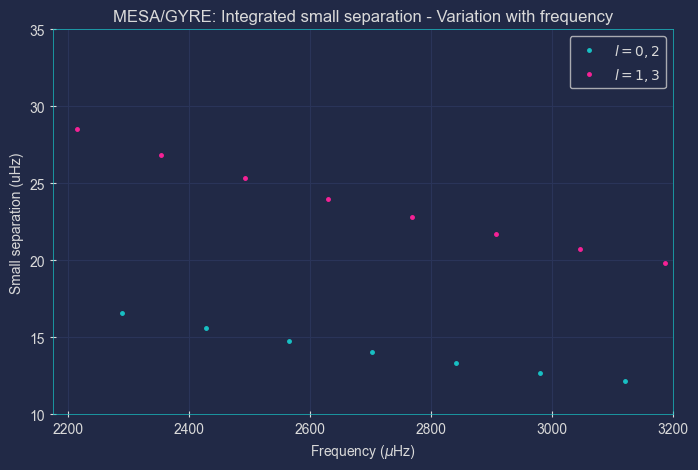

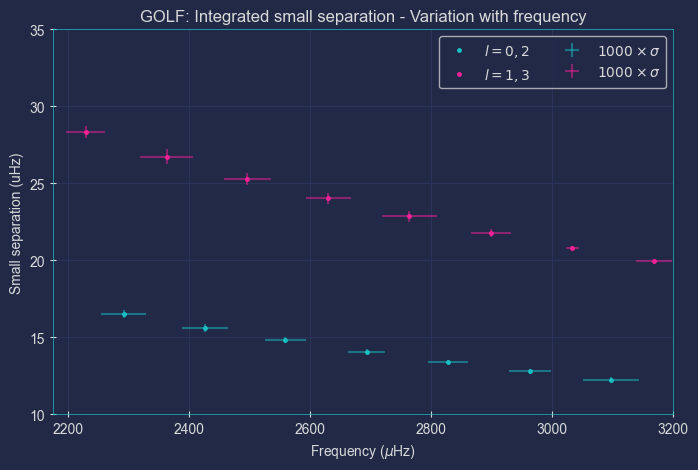

In [513]:
sl02_MESA, sl13_MESA, Integrated_small_seps_MESA = \
    Freqs_MESA_obj.small_sep_plot_Integrated(xlim = (2.175e3, 3.2e3), \
                                             ylim = (10., 35.), \
                                             append_name = 'MESA_detail', \
                                             title = 'MESA/GYRE: Integrated small separation - Variation with frequency')
sl02GOLF, Sl13GOLF, Integrated_small_seps_GOLF = \
    Freqs_GOLF_obj.small_sep_plot_Integrated(xlim = (2.175e3, 3.2e3), \
                                             ylim = (10., 35.), \
                                             append_name = 'GOLF_detail', \
                                             title = 'GOLF: Integrated small separation - Variation with frequency')

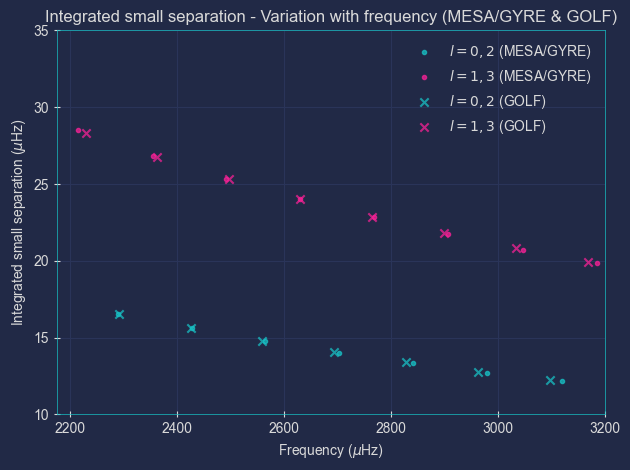

In [514]:
# Comparison plots between MESA/GYRE and GOLF
plt.scatter(sl02_MESA[:, 0], sl02_MESA[:, 1], label = r'$l = 0, 2$ (MESA/GYRE)', color = 'C0', marker = '.', alpha = 0.75)
plt.scatter(sl13_MESA[:, 0], sl13_MESA[:, 1], label = r'$l = 1, 3$ (MESA/GYRE)', color = 'C1', marker = '.', alpha = 0.75)
plt.scatter(sl02GOLF[:, 0], sl02GOLF[:, 1], label = r'$l = 0, 2$ (GOLF)', color = 'C6', marker = 'x', alpha = 0.75)
plt.scatter(Sl13GOLF[:, 0], Sl13GOLF[:, 1], label = r'$l = 1, 3$ (GOLF)', color = 'C7', marker = 'x', alpha = 0.75)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel(r'Integrated small separation ($\mu$Hz)')
plt.xlim(2.175e3, 3.2e3); plt.ylim(10., 35.)
plt.title('Integrated small separation - Variation with frequency (MESA/GYRE & GOLF)')
plt.legend()
plt.tight_layout()
plt.savefig('./Figures/SmallSeparationIntegrated_Comparison.png', dpi = 300)
plt.show()

This means there's probably a mistake in the identification of the frequencies with the correct $n$ and $l$ values.

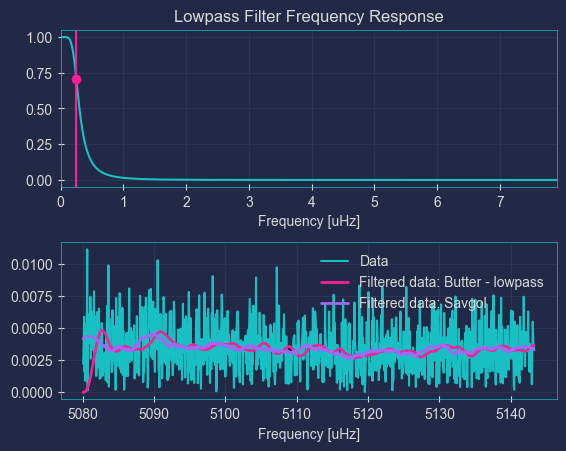

In [515]:
# Test block
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

xData = test_obj.xData_window
yData = test_obj.yData_window

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 3
fs = 1/(xData[1] - xData[0]) # sample rate, Hz
cutoff = 0.25  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h))
plt.plot(cutoff, 0.5*np.sqrt(2), 'C1o')
plt.axvline(cutoff, color='C1')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [uHz]')

# Demonstrate the use of the filter.
# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(yData, cutoff, fs, order)
yhat = savgol_filter(yData, 90, 3) # window size 51, polynomial order 3

plt.subplot(2, 1, 2)
plt.plot(xData, yData, label='Data')
plt.plot(xData, y, linewidth=2, label='Filtered data: Butter - lowpass')
plt.plot(xData, yhat, linewidth=2, label='Filtered data: Savgol')
plt.xlabel('Frequency [uHz]')
plt.legend()

plt.subplots_adjust(hspace = 0.35)
plt.show()

I'm missing the plot of the large (small) separation as a function of frequency:
- Select, e.g., $l = 0$;
- For $\Delta\nu_{n, l = 0} \equiv \nu_{n+1, l = 0} - \nu_{n, l = 0}$, consider the frequency at mode $n, f_n$
This should be implemented in the `Stellar_freqs` class.

Question: what are the GYRE frequency's uncertainties? How do we obtain them?
Also, I really don't know why my small separation values, for the pair $l = 0, 2$ is so large.

`Creative part: (Tests and examples)`
- Determination of the solar radius from the large separation and speed of sound values. Note: the `csound` value was estimated, by eye, from the sound speed profiles of Part 1. To be more accurate compute the actual sound speed average from these values explicitly.

In [516]:
csound = 2.5e5 # Approximate
# Solar radius in km
Rsun = 6.957e5
Rsun_Exp = csound/(2*np.mean(large_l0_MESA)*10**-6*1000)
print(f'*** Comparison of the solar radius ***')
print(f'MESA/GYRE:  Rsun = {Rsun_Exp:.3f} km.')
print(f'Literature: Rsun = {Rsun:.3f} km.')
print(f'Rel. error: Rsun = {np.abs(Rsun_Exp - Rsun)/Rsun * 100:.3f} %.')

*** Comparison of the solar radius ***
MESA/GYRE:  Rsun = 589480.741 km.
Literature: Rsun = 695700.000 km.
Rel. error: Rsun = 15.268 %.


- Plot of the large separation $vs.$ small separation (there's something wrong here, possible $n_p$ values are mismatched)

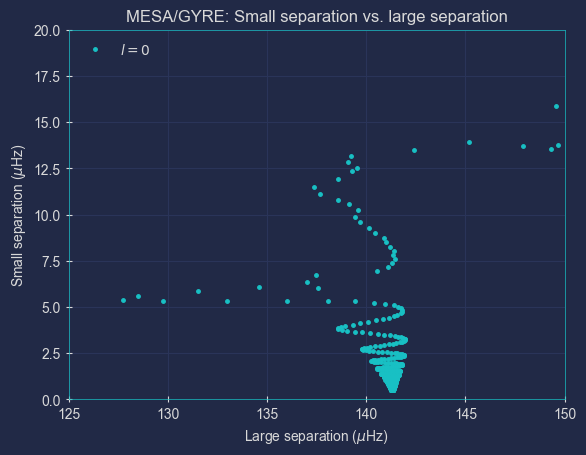

In [517]:
# Making sure n_p values are matched
matches = []
for i in range(len(small_l0_MESA)):
    for j in range(len(large_l0_MESA)):
        if(int(small_l0_MESA[i][1]) == int(large_l0_MESA[j][1])):
            matches.append((large_l0_MESA[j][0], small_l0_MESA[i][0], int(large_l0_MESA[j][1]), int(small_l0_MESA[i][1])))
            pass
# Plotting results
plt.plot([match[0] for match in matches], [match[1] for match in matches], 'o', markersize = 2.5, color = 'C0', label = r'$l = 0$')
plt.xlim(125, 150)
plt.ylim(0, 20)
plt.xlabel(r'Large separation ($\mu$Hz)')
plt.ylabel(r'Small separation ($\mu$Hz)')
plt.title('MESA/GYRE: Small separation vs. large separation')
plt.legend()
plt.show()

# Check this: https://articles.adsabs.harvard.edu//full/1993ASPC...42..347C/0000348.000.html
# Apparently I should be plotting some averages. Check the paper above for more info.
# As a consequence, this would result in a single point in the plot below (not too interesting, in our case).

- Echelle diagrams:

Plotting Echelle diagram... Using $\Delta \nu$ = 141.19111454020975 uHz.


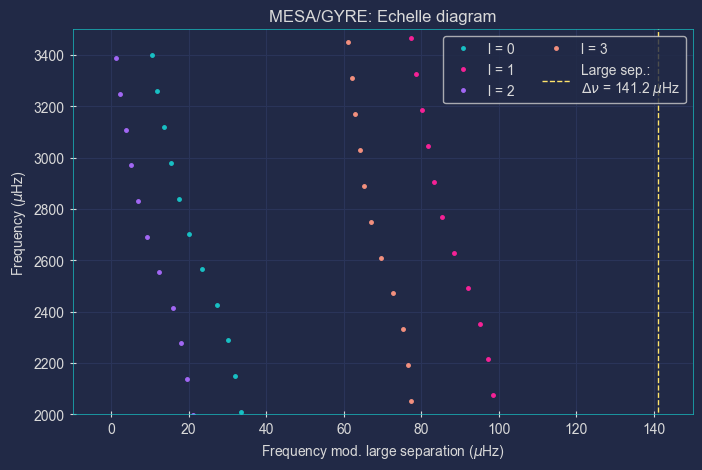

Plotting Echelle diagram... Using $\Delta \nu$ = 134.61693311687262 uHz.


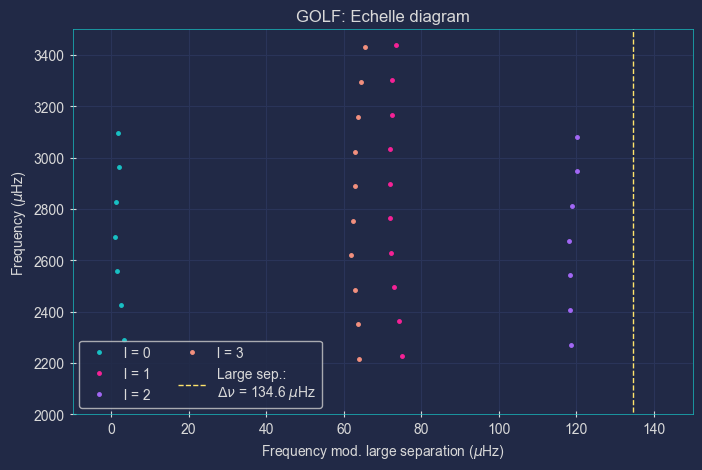

In [518]:
echelle_dict_MESA = Freqs_MESA_obj.plot_echelle(xlim = (-10, 150), ylim = (2.0e3, 3.5e3), \
                                                title = 'MESA/GYRE: Echelle diagram', append_name = 'MESA_detail')
echelle_dict_GOLF = Freqs_GOLF_obj.plot_echelle(xlim = (-10, 150), ylim = (2.0e3, 3.5e3), \
                                                title = 'GOLF: Echelle diagram', append_name = 'GOLF_detail')

Código Bea: (Fit a 10 Lorentzianas simulataneamente)

In [519]:
# Reading the data (+ definitions)
xBea, yBea = xf*1e6, 2.0/N * np.abs(y12f[:N//2])
Data_Bea = pd.read_excel('c:/Users/afons/Downloads/ASTRO_FINAL_EX_2.xlsx', \
                         dtype = {'  l   ': 'Int64', 'n_p      ': 'Int64'})

# Ten Lorentzian functions, to fit the data to!
def Ten_Lorentz(x, a, b, \
                A, w, x_0, \
                    A1, w1, x_01, \
                        A2, w2, x_02, \
                            A3, w3, x_03, \
                                A4, w4, x_04, \
                                    A5, w5, x_05, \
                                        A6, w6, x_06, \
                                            A7, w7, x_07, \
                                                A8, w8, x_08, \
                                                    A9, w9, x_09):
    return a*x + b + \
            (2*A/np.pi)*(w/(4*(x-x_0)**2 + w**2)) + \
                (2*A1/np.pi)*(w1/(4*(x-x_01)**2 + w1**2)) + \
                    (2*A2/np.pi)*(w2/(4*(x-x_02)**2 + w2**2)) + \
                        (2*A3/np.pi)*(w3/(4*(x-x_03)**2 + w3**2)) + \
                            (2*A4/np.pi)*(w4/(4*(x-x_04)**2 + w4**2)) + \
                                (2*A5/np.pi)*(w5/(4*(x-x_05)**2 + w5**2)) + \
                                    (2*A6/np.pi)*(w6/(4*(x-x_06)**2 + w6**2)) + \
                                        (2*A7/np.pi)*(w7/(4*(x-x_07)**2 + w7**2)) + \
                                            (2*A8/np.pi)*(w8/(4*(x-x_08)**2 + w8**2)) + \
                                                (2*A9/np.pi)*(w9/(4*(x-x_09)**2 + w9**2))

# Taken from my other fits ;)
Manual_initialParameters = [-1.068e-05, 3.325e-02, \
                            0.10814, 2.65376, 2889.83378, \
                            0.08804, 1.61460, 2898.85324, \
                            0.05681, 4.06278, 2947.19465, \
                            0.17758, 2.33168, 2963.66171, \
                            0.15517, 3.09188, 3024.40998, \
                            0.06203, 0.56525, 3033.61974, \
                            0.06187, 3.69389, 3081.84130, \
                            0.21532, 3.09435, 3098.03048, \
                            0.14864, 4.08869, 3159.77375, \
                            0.14219, 1.64030, 3168.65460]
fittedParameters, pcov = curve_fit(Ten_Lorentz, xBea, yBea, Manual_initialParameters)

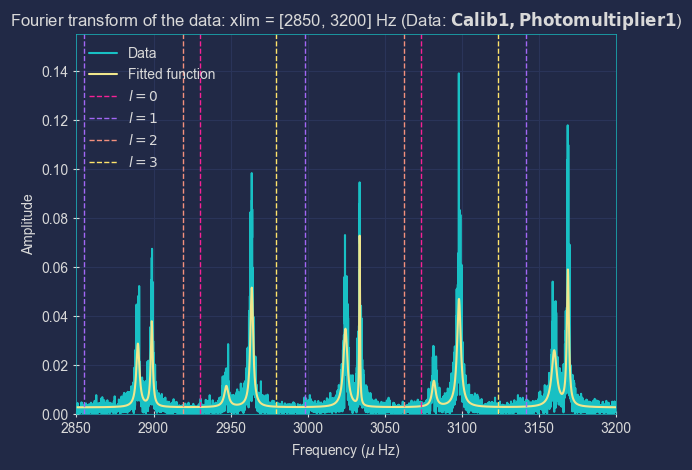

a = -1.181e-07, b = 3.206e-03;
Peak 1: A  = 0.10174, w  = 2.51543, x_0  = 2889.85028;
Peak 2: A1 = 0.08302, w1 = 1.52647, x_01 = 2898.85129;
Peak 3: A2 = 0.04378, w2 = 3.26395, x_02 = 2947.22278;
Peak 4: A3 = 0.16882, w3 = 2.20481, x_03 = 2963.67788;
Peak 5: A4 = 0.15924, w4 = 3.16806, x_04 = 3024.41658;
Peak 6: A5 = 0.06350, w5 = 0.58524, x_05 = 3033.61912;
Peak 7: A6 = 0.04677, w6 = 2.83822, x_06 = 3081.75772;
Peak 8: A7 = 0.20245, w7 = 2.92045, x_07 = 3098.02744;
Peak 9: A8 = 0.14523, w8 = 4.04250, x_08 = 3159.77556;
Peak 10: A9 = 0.14005, w9 = 1.61751, x_09 = 3168.65511.


In [520]:
# Create values for display of fitted peak function
a, b, A, w, x_0, A1, w1, x_01, A2, w2, x_02, A3, w3, x_03, A4, w4, x_04, A5, w5, x_05, A6, w6, x_06, A7, w7, x_07, A8, w8, x_08, A9, w9, x_09 = fittedParameters
y_fit = Ten_Lorentz(xBea, *fittedParameters)

# Plot the peak data
plt.plot(xBea, yBea,  label='Data')
plt.plot(xBea, y_fit, color = 'khaki', label='Fitted function')

# GYRE frequencies
flag_0, flag_1, flag_2, flag_3 = False, False, False, False
for index, row in Data_Bea.iterrows():
    color = '';
    match row['  l   ']:
        case 0:
            color = 'C1'
            if(flag_0 == False):
                plt.vlines(row['Re(freq)09'], ymin = 0.0, ymax = 0.155, color = color, linewidth = 1, \
                           linestyle = '--', label = rf'$l = {row["  l   "]}$')
            flag_0 = True
        case 1:
            color = 'C2'
            if(flag_1 == False):
                plt.vlines(row['Re(freq)09'], ymin = 0.0, ymax = 0.155, color = color, linewidth = 1, \
                           linestyle = '--', label = rf'$l = {row["  l   "]}$')
            flag_1 = True
        case 2:
            color = 'C3'
            if(flag_2 == False):
                plt.vlines(row['Re(freq)09'], ymin = 0.0, ymax = 0.155, color = color, linewidth = 1, \
                           linestyle = '--', label = rf'$l = {row["  l   "]}$')
            flag_2 = True
        case 3:
            color = 'C4'
            if(flag_3 == False):
                plt.vlines(row['Re(freq)09'], ymin = 0.0, ymax = 0.155, color = color, linewidth = 1, \
                           linestyle = '--', label = rf'$l = {row["  l   "]}$')
            flag_3 = True
    plt.vlines(row['Re(freq)09'], ymin = 0.0, ymax = 0.155, color = color, linewidth = 1, \
               linestyle = '--')
plt.xlim(2850, 3200)
plt.ylim(0.0, 0.155)
plt.xlabel(r'Frequency ($\mu$ Hz)')
plt.ylabel('Amplitude')
plt.title(r'Fourier transform of the data: xlim = [2850, 3200]' + r' Hz (Data: $\mathbf{Calib1, Photomultiplier1}$)')
plt.legend()
plt.tight_layout()
plt.show()

# Printing fit results
print(f'a = {a:.3e}, b = {b:.3e};\n\
Peak 1: A  = {A:.5f}, w  = {w:.5f}, x_0  = {x_0:.5f};\n\
Peak 2: A1 = {A1:.5f}, w1 = {w1:.5f}, x_01 = {x_01:.5f};\n\
Peak 3: A2 = {A2:.5f}, w2 = {w2:.5f}, x_02 = {x_02:.5f};\n\
Peak 4: A3 = {A3:.5f}, w3 = {w3:.5f}, x_03 = {x_03:.5f};\n\
Peak 5: A4 = {A4:.5f}, w4 = {w4:.5f}, x_04 = {x_04:.5f};\n\
Peak 6: A5 = {A5:.5f}, w5 = {w5:.5f}, x_05 = {x_05:.5f};\n\
Peak 7: A6 = {A6:.5f}, w6 = {w6:.5f}, x_06 = {x_06:.5f};\n\
Peak 8: A7 = {A7:.5f}, w7 = {w7:.5f}, x_07 = {x_07:.5f};\n\
Peak 9: A8 = {A8:.5f}, w8 = {w8:.5f}, x_08 = {x_08:.5f};\n\
Peak 10: A9 = {A9:.5f}, w9 = {w9:.5f}, x_09 = {x_09:.5f}.')